# Experiments

In [1]:
# Import.
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from models.principal_rbm_alpha import RBM
from models.principal_dbn_alpha import DBN
from models.principal_dnn_mnist import DNN
from utils import (
    load_mnist,
    load_alphadigit,
    read_alpha_digit,
    plot_characters_alphadigit,
    plot_original_and_generated_images
)

In [2]:
DATA_FOLDER = "../data/"
ALPHA_DIGIT_PATH = os.path.join(DATA_FOLDER, "binaryalphadigs.mat")
MNIST_PATH = os.path.join(DATA_FOLDER, "mnist_all.mat")

for path in [ALPHA_DIGIT_PATH, MNIST_PATH]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"The file {path} does not exist.")

SEED = 42

## 1. Study on BinaryAlphaDigit

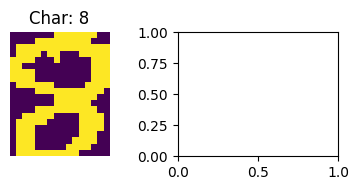

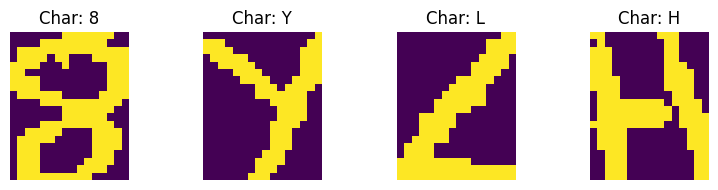

Original data: (36, 39)
Original data (unstack samples -> flatten images): (1365, 320)
Subset (1 character) data  (39, 320)
Subset (4 characters) data  (156, 320)


In [3]:
alphadigit = load_alphadigit(ALPHA_DIGIT_PATH)

chars_1 = [8]
chars_2 = chars_1 + ["Y"]
chars_3 = chars_2 + ["L"]
chars_4 = chars_3 + ["H"]
data_alpha_1 = read_alpha_digit(chars_1, data=alphadigit, use_data=True)
data_alpha_2 = read_alpha_digit(chars_2, data=alphadigit, use_data=True)
data_alpha_3 = read_alpha_digit(chars_3, data=alphadigit, use_data=True)
data_alpha_4 = read_alpha_digit(chars_4, data=alphadigit, use_data=True)

all_chars = np.arange(0, 35).tolist()
alphadigit_data = read_alpha_digit(all_chars, data=alphadigit, use_data=True) # read all characters

plot_characters_alphadigit(chars_1, data_alpha_1)
plot_characters_alphadigit(chars_4, data_alpha_4)

print("Original data:", alphadigit.shape)
print("Original data (unstack samples -> flatten images):", alphadigit_data.shape)
print(f"Subset ({len(chars_1)} character) data ", data_alpha_1.shape)
print(f"Subset ({len(chars_4)} characters) data ", data_alpha_4.shape)

### RBM

In [4]:
data_alpha = data_alpha_1
n_chars = data_alpha.shape[0] / 39

# Parameters
n_visible = data_alpha.shape[1]  # Number of visible units (size of each image)
n_hidden = 200  # Number of hidden units (hyperparameter)
learning_rate = 0.1
n_epochs = 100
batch_size = int(8 * n_chars)

# Initialize RBM
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, random_state=SEED)
print(rbm)

# Train RBM
rbm.train(data_alpha, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size)

RBM(n_visible=320, n_hidden=200)


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 625.16it/s]


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 833.29it/s]


RBM(n_visible=320, n_hidden=200)

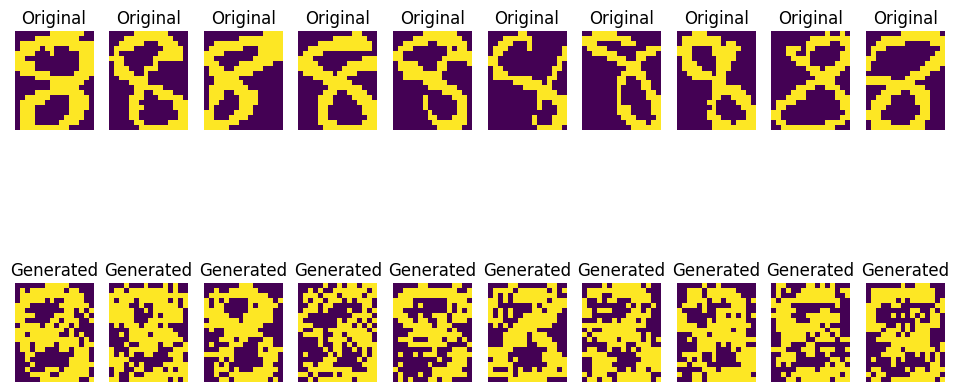

In [5]:
# Generate samples
generated_samples = rbm.generate_image(n_samples=10, n_gibbs_steps=1)

plot_original_and_generated_images(data_alpha, generated_samples, **{"cmap":None})

### DBN

In [6]:
data_alpha = data_alpha_1
n_chars = data_alpha.shape[0] / 39

# Parameters
n_visible = data_alpha.shape[1]  # Number of visible units (size of each image)
n_hidden = 200  # Number of hidden units (hyperparameter)
hidden_layer_sizes = [200, 200, 200]

learning_rate = 0.1
n_epochs = 100
batch_size = int(8 * n_chars)

dbn = DBN(n_visible=n_visible, hidden_layer_sizes=hidden_layer_sizes, random_state=SEED)
dbn.train(data_alpha, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size)

Training RBM layers: 100%|██████████| 3/3 [00:03<00:00,  1.25s/layer]


DBN([
 RBM(n_visible=320, n_hidden=200),
 RBM(n_visible=200, n_hidden=200),
 RBM(n_visible=200, n_hidden=200)
])

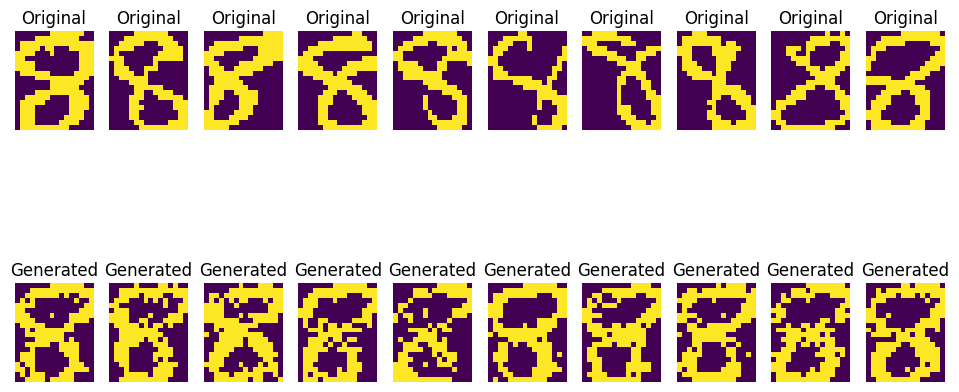

In [7]:
# # Generate images
generated_images = dbn.generate_image(n_samples=10, n_gibbs_steps=1)

# Display generated images
plot_original_and_generated_images(data_alpha, generated_images, **{"cmap":None})

### MNIST

In [8]:
import scipy.io

In [9]:
def load_mnist(mnist_path, mnist_dict=None, use_dict=False):
    if not use_dict:
        mnist_dict = scipy.io.loadmat(mnist_path)
    
    X_train = np.concatenate([mnist_dict[f"train{i}"] for i in range(10)], axis=0)
    X_test = np.concatenate([mnist_dict[f"test{i}"] for i in range(10)], axis=0)
    
    y_train = np.concatenate([np.eye(10)[[i]*mnist_dict[f"train{i}"].shape[0]] for i in range(10)], axis=0)
    y_test = np.concatenate([np.eye(10)[[i]*mnist_dict[f"test{i}"].shape[0]] for i in range(10)], axis=0)

    return X_train, y_train, X_test, y_test


def sample_indices(data_size: int, sample_size: int, random_state=None) -> np.ndarray:
    """
    Randomly sample indices from the range [0, data_size) without replacement.

    Parameters:
        data_size (int): Total number of indices available.
        sample_size (int): Number of indices to sample.
        random_state: Random seed for reproducibility.

    Returns:
        numpy.ndarray: Array of sampled indices.
    """
    rng = np.random.default_rng(random_state)
    if sample_size >= data_size:
        return np.arange(data_size)

    sampled_indices = rng.choice(data_size, size=sample_size, replace=False)
    return sampled_indices

def sample_mnist(X_train: np.ndarray, y_train: np.ndarray, sample_size: int, random_state=None) -> tuple:
    """
    Randomly sample a subset of samples from the MNIST dataset.

    Parameters:
        X_train (numpy.ndarray): Training data.
        y_train (numpy.ndarray): Training labels.
        sample_size (int): Number of samples to sample.
        random_state: Random seed for reproducibility.

    Returns:
        tuple: Sampled subset of training data and labels.
    """
    # Sample indices
    indices = sample_indices(len(X_train), sample_size, random_state=random_state)
    
    # Sample data and labels
    sampled_X_train = X_train[indices]
    sampled_y_train = y_train[indices]
    
    return sampled_X_train, sampled_y_train


def binarize_images(images):
    threshold = 127
    binary_images = np.where(images > threshold, 1, 0)
    return binary_images

mnist_train, mnist_train_labels, mnist_test, mnist_test_labels = (
    load_mnist(MNIST_PATH)
)


# Binarize the images
binary_mnist_train = binarize_images(mnist_train)
binary_mnist_test = binarize_images(mnist_test)


[mnist.shape for mnist in (mnist_train, mnist_train_labels, mnist_test, mnist_test_labels)]

[(60000, 784), (60000, 10), (10000, 784), (10000, 10)]

In [10]:
mnist_train_30000, mnist_train_labels_30000 = sample_mnist(mnist_train, mnist_train_labels, 30_000, 42)
mnist_train_30000.shape, mnist_train_labels_30000.shape

((30000, 784), (30000, 10))

In [11]:
print(mnist_train.max(), binary_mnist_train.max())

255 1


MNIST (60000, 28, 28)


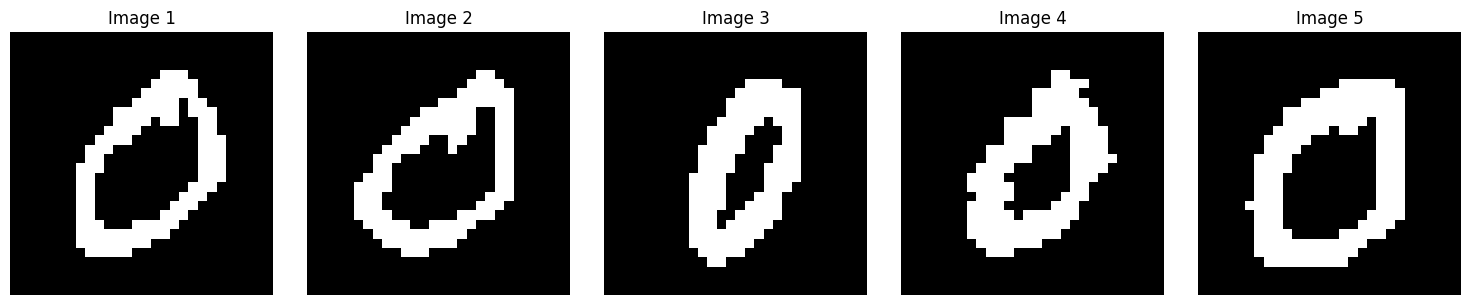

In [12]:
# Reshape mnist_train to its original shape
image_height = 28
image_width = 28
num_samples = binary_mnist_train.shape[0]
binary_mnist_train_images = binary_mnist_train.reshape(num_samples, image_height, image_width)
print("MNIST", binary_mnist_train_images.shape)

# Plot some images from mnist_train
num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))
for i in range(num_images_to_plot):
    axes[i].imshow(binary_mnist_train_images[i], cmap='gray')
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
help(DNN)

Help on class DNN in module models.principal_dnn_mnist:

class DNN(models.principal_dbn_alpha.DBN)
 |  DNN(input_dim: int, output_dim: int, hidden_layer_sizes: List[int], random_state=None)
 |  
 |  Method resolution order:
 |      DNN
 |      models.principal_dbn_alpha.DBN
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, key)
 |  
 |  __init__(self, input_dim: int, output_dim: int, hidden_layer_sizes: List[int], random_state=None)
 |      Initialize the Deep Neural Network (DNN).
 |      
 |      Parameters:
 |      - input_dim (int): Dimension of the input.
 |      - output_dim (int): Dimension of the output.
 |      - hidden_layer_sizes (List[int]): List of sizes for each hidden layer.
 |      - random_state: Random seed for reproducibility.
 |  
 |  __len__(self)
 |  
 |  __repr__(self)
 |      Return a string representation of the DBN object.
 |  
 |  backpropagation(self, input_data: numpy.ndarray, labels: numpy.ndarray, n_epochs: int = 100, learn

In [14]:
from copy import copy, deepcopy

In [15]:
from typing import Tuple

def run_experiment_dnn(
    # data
    train_data,
    train_labels,
    test_data,
    test_labels,
    # initialization
    input_dim,
    output_dim,
    hidden_layer_sizes,
    # training
    batch_size=64,
    n_epochs_pretrain=100,
    n_epochs_backprop=200,
    learning_rate=0.1,
    eps=1e-15,
    print_each=20,
    verbose=True,
    random_state=42,     
) -> Tuple[float, float]:
    """
    Run an experiment with Deep Neural Networks (DNNs).

    Parameters:
        train_data (numpy.ndarray): Training data.
        train_labels (numpy.ndarray): Training labels.
        test_data (numpy.ndarray): Test data.
        test_labels (numpy.ndarray): Test labels.
        input_dim (int): Dimensionality of input data.
        output_dim (int): Dimensionality of output data.
        hidden_layer_sizes (list): List of sizes of hidden layers.
        random_state (int): Random seed for reproducibility. Default is 42.
        n_epochs_pretrain (int): Number of epochs for pretraining. Default is 100.
        n_epochs_backprop (int): Number of epochs for backpropagation. Default is 200.
        learning_rate (float): Learning rate for training. Default is 0.1.
        batch_size (int): Batch size for training. Default is 64.
        print_each (int): Frequency of printing progress. Default is 20.
        verbose (bool): Whether to print progress. Default is True.
        eps (float): Small value to avoid division by zero. Default is 1e-15.

    Returns:
        Tuple[float, float]: Error rates for random initialization and pretrained models.
    """
    # 1. Intialization.
    dnn = DNN(
            input_dim=input_dim, 
            output_dim=output_dim, 
            hidden_layer_sizes=hidden_layer_sizes,
            random_state=random_state
    )

    ## 1.1 Initialized random weights DNN.
    dnn_random_init = deepcopy(dnn)
    
    ## 1.2.1 Pretrain DBN component.
    print("\n--------- PRETRAINING PHASE --------\n")
    dnn.pretrain(
            n_epochs=n_epochs_pretrain,
            learning_rate=learning_rate,
            batch_size=batch_size,
            data=train_data,
            # print_each=print_each,
            # verbose=verbose
    )
    ## 1.2.2 Initialized pre-trained DNN.                
    dnn_pretrained = deepcopy(dnn)

    # 2. Training phase (backpropagation).
    backprop_params = {
            "input_data": train_data, 
            "labels": train_labels, 
            "n_epochs": n_epochs_backprop, 
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            # "print_each": print_each,
            # "verbose": verbose, 
            "eps": eps
    }
    print("\n\n--------- BACKPROPAGATION --------")
    dnn_random_init.backpropagation(**backprop_params)
    dnn_pretrained.backpropagation(**backprop_params)

    # 3. Evaluation phase.
    train_params = {"test_data": train_data, "true_labels": train_labels}
    train_error_random_init = dnn_random_init.test(**train_params)
    train_error_pretrained = dnn_pretrained.test(**train_params)
    
    test_params = {"test_data": train_data, "true_labels": train_labels}
    test_error_random_init = dnn_random_init.test(**test_params)
    test_error_pretrained = dnn_pretrained.test(**test_params)

    return train_error_random_init, train_error_pretrained, test_error_random_init, test_error_pretrained


import pickle

def save_object(obj, file_path):
    """
    Save an object to a file using pickle.

    Parameters:
        obj: The object to save.
        file_path (str): The path to the file where the object will be saved.
    """
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)



import os

def save_results(error_rates, experiment_type, parameter_value, hidden_layer_sizes, train_size, save_dir):
    """
    Save experiment results to a file.

    Parameters:
        error_rate_random_init (float): Error rate for randomly initialized networks.
        error_rate_pretrained (float): Error rate for pretrained networks.
        experiment_type (str): Type of experiment ('layers', 'neurons', 'train_size').
        parameter_value: Value of the parameter being varied.
        hidden_layer_sizes (list): Sizes of hidden layers.
        train_size (int): Number of training data points.
        save_dir (str): Directory to save the results.
    """
    # Create directory if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Construct filename
    filename = f"error_rates_{experiment_type}_{parameter_value}_{len(hidden_layer_sizes)}layers_{'_'.join(map(str, hidden_layer_sizes))}_{train_size}.txt"
    filepath = os.path.join(save_dir, filename)

    # Save results to file
    with open(filepath, 'w') as file:
        file.write("Error Rate for Random Initialization [Train]:\n")
        file.write(f"{error_rates[0]}\n")

        file.write("Error Rate for Pretrained Network:\n")
        file.write(f"{error_rates[1]}\n")

        file.write("Error Rate for Random Initialization [Test]:\n")
        file.write(f"{error_rates[2]}\n")

        file.write("Error Rate for Pretrained Network [Test]:\n")
        file.write(f"{error_rates[3]}\n")

    print(f"Results saved to: {filepath}")



In [16]:
from joblib import Parallel, delayed

In [21]:
def experiment_layers(train_data, train_labels, test_data, test_labels, save_dir):
    num_layers = [2, 3, 4, 5]  # Number of layers
    error_rates_dict = {}

    for num_layer in num_layers:
        hidden_layer_sizes = [200] * num_layer
        error_rates = run_experiment_dnn(
            train_data=train_data,
            train_labels=train_labels,
            test_data=test_data,
            test_labels=test_labels,
            input_dim=train_data.shape[1],
            output_dim=train_labels.shape[1],
            hidden_layer_sizes=hidden_layer_sizes,
        )
        error_rates_dict[num_layer] = error_rates
        save_results(error_rates, 'layers', num_layer, hidden_layer_sizes,
                     train_data.shape[0], save_dir)
        
    return error_rates_dict

def experiment_neurons(train_data, train_labels, test_data, test_labels, save_dir, layer_sizes=[200, 300, 400, 500]):
    error_rates_random_init = []
    error_rates_pretrained = []
    
    for layer_size in layer_sizes:
        hidden_layer_sizes = [layer_size] * 2  # Using 2 layers of the specified size
        
        print(f"Running experiment with hidden layers of sizes: {hidden_layer_sizes}")

        # Run the experiment with the DNN
        train_error_random_init, train_error_pretrained, test_error_random_init, test_error_pretrained = run_experiment_dnn(
            train_data=train_data,
            train_labels=train_labels,
            test_data=test_data,
            test_labels=test_labels,
            input_dim=train_data.shape[1],
            output_dim=train_labels.shape[1],
            hidden_layer_sizes=hidden_layer_sizes,
        )

        # Append the error rates for analysis
        error_rates_random_init.append((train_error_random_init, test_error_random_init))
        error_rates_pretrained.append((train_error_pretrained, test_error_pretrained))

        # Save the results after each iteration to avoid data loss in case of interruption
        save_results(
            (train_error_random_init, train_error_pretrained, test_error_random_init, test_error_pretrained),
            'neurons', layer_size, hidden_layer_sizes, train_data.shape[0], save_dir
        )
        
    return error_rates_random_init, error_rates_pretrained


def experiment_train_size(
        train_data,
        train_labels,
        test_data,
        test_labels,
        save_dir, 
        train_sizes=[1000, 3000, 7000, 10000, 30000, 60000]
    ):
    error_rates_random_init = []
    error_rates_pretrained = []

    for train_size in train_sizes:
        print(f"Running experiment with training size: {train_size}")
        sampled_train_data, sampled_train_labels = sample_mnist(train_data, train_labels, train_size)
        
        train_error_random_init, train_error_pretrained, test_error_random_init, test_error_pretrained = run_experiment_dnn(
            train_data=sampled_train_data,
            train_labels=sampled_train_labels,
            test_data=test_data,
            test_labels=test_labels,
            input_dim=sampled_train_data.shape[1],
            output_dim=train_labels.shape[1],
            hidden_layer_sizes=[200, 200],  # Fixed to 2 layers of 200 neurons
        )

        # Append both training and testing error rates for random initialization and pretrained models
        error_rates_random_init.append((train_error_random_init, test_error_random_init))
        error_rates_pretrained.append((train_error_pretrained, test_error_pretrained))

        # Save the results after each train size experiment
        save_results(
            (train_error_random_init, train_error_pretrained, test_error_random_init, test_error_pretrained),
            'train_size', train_size, [200, 200], train_size, save_dir
        )

    return error_rates_random_init, error_rates_pretrained


In [17]:
data = mnist_train.copy()
n_samples, n_visible = data.shape # n_samples, n_features
n_visible = data.shape[1]
hidden_layer_sizes = [100, 50, 25]
n_classes = mnist_test_labels.shape[1]

dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)

# dnn.train(data, learning_rate=0.1, n_epochs=10, batch_size=10)


In [18]:
# dnn.backpropagation(mnist_train, labels=mnist_train_labels)

In [18]:
train_1000, train_1000_labels = sample_mnist(binary_mnist_train, mnist_train_labels, 1_000, random_state=SEED)
train_1000.shape

(1000, 784)

In [20]:
train, train_labels = train_1000, train_1000_labels
n_classes = train_1000_labels.shape[1]

run_experiment_dnn(
    # data
    train_data=train,
    train_labels=train_labels,
    test_data=mnist_test,
    test_labels=mnist_test_labels,
    # initialization
    input_dim=train.shape[1],
    output_dim=n_classes,
    hidden_layer_sizes=[200],
    # training
    batch_size=128,
    n_epochs_pretrain=100,
    n_epochs_backprop=200,
    learning_rate=0.1,
    eps=1e-15,
    print_each=20,
    verbose=True,
    random_state=42
)


--------- PRETRAINING PHASE --------



Training RBM layers: 100%|██████████| 1/1 [00:08<00:00,  9.00s/layer]




--------- BACKPROPAGATION --------


Training:   3%|▎         | 6/200 [00:00<00:03, 52.63epoch/s]

Epoch 1/200, Cross Entropy: 2.2863620255975663
Epoch 2/200, Cross Entropy: 2.2795997110457806
Epoch 3/200, Cross Entropy: 2.2775048581972386
Epoch 4/200, Cross Entropy: 2.276741967403284
Epoch 5/200, Cross Entropy: 2.276441913721445
Epoch 6/200, Cross Entropy: 2.276318975197376
Epoch 7/200, Cross Entropy: 2.2762673004406553
Epoch 8/200, Cross Entropy: 2.2762451741317364
Epoch 9/200, Cross Entropy: 2.2762355565026207


Training:   3%|▎         | 6/200 [00:00<00:03, 52.63epoch/s]

Epoch 10/200, Cross Entropy: 2.2762313186075787


Training:   9%|▉         | 18/200 [00:00<00:03, 53.21epoch/s]

Epoch 11/200, Cross Entropy: 2.2762294241066083
Epoch 12/200, Cross Entropy: 2.2762285611610262
Epoch 13/200, Cross Entropy: 2.27622815627367
Epoch 14/200, Cross Entropy: 2.2762279562517076
Epoch 15/200, Cross Entropy: 2.276227848394944
Epoch 16/200, Cross Entropy: 2.2762277821987023
Epoch 17/200, Cross Entropy: 2.2762277349050186
Epoch 18/200, Cross Entropy: 2.2762276962132613
Epoch 19/200, Cross Entropy: 2.276227661444755


Training:   9%|▉         | 18/200 [00:00<00:03, 53.21epoch/s]

Epoch 20/200, Cross Entropy: 2.2762276284685683


Training:  12%|█▏        | 24/200 [00:00<00:03, 52.07epoch/s]

Epoch 21/200, Cross Entropy: 2.276227596312142
Epoch 22/200, Cross Entropy: 2.27622756453093
Epoch 23/200, Cross Entropy: 2.276227532921522
Epoch 24/200, Cross Entropy: 2.2762275013907853
Epoch 25/200, Cross Entropy: 2.2762274698960665
Epoch 26/200, Cross Entropy: 2.27622743841783
Epoch 27/200, Cross Entropy: 2.276227406947132
Epoch 28/200, Cross Entropy: 2.2762273754798787


Training:  12%|█▏        | 24/200 [00:00<00:03, 52.07epoch/s]

Epoch 29/200, Cross Entropy: 2.276227344014198


Training:  15%|█▌        | 30/200 [00:00<00:03, 51.46epoch/s]

Epoch 30/200, Cross Entropy: 2.276227312549235
Epoch 31/200, Cross Entropy: 2.276227281084599


Training:  18%|█▊        | 36/200 [00:00<00:05, 31.69epoch/s]

Epoch 32/200, Cross Entropy: 2.276227249620113
Epoch 33/200, Cross Entropy: 2.276227218155695
Epoch 34/200, Cross Entropy: 2.276227186691309
Epoch 35/200, Cross Entropy: 2.276227155226938
Epoch 36/200, Cross Entropy: 2.2762271237625744
Epoch 37/200, Cross Entropy: 2.276227092298215
Epoch 38/200, Cross Entropy: 2.2762270608338584
Epoch 39/200, Cross Entropy: 2.2762270293695037


Training:  23%|██▎       | 46/200 [00:01<00:04, 35.15epoch/s]

Epoch 40/200, Cross Entropy: 2.2762269979051504
Epoch 41/200, Cross Entropy: 2.2762269664407984
Epoch 42/200, Cross Entropy: 2.2762269349764486
Epoch 43/200, Cross Entropy: 2.2762269035120997
Epoch 44/200, Cross Entropy: 2.2762268720477516
Epoch 45/200, Cross Entropy: 2.276226840583406
Epoch 46/200, Cross Entropy: 2.2762268091190614
Epoch 47/200, Cross Entropy: 2.276226777654718


Epoch 48/200, Cross Entropy: 2.2762267461903756
Epoch 49/200, Cross Entropy: 2.2762267147260355
Epoch 50/200, Cross Entropy: 2.276226683261697
Epoch 51/200, Cross Entropy: 2.2762266517973586
Epoch 52/200, Cross Entropy: 2.276226620333022


Training:  28%|██▊       | 56/200 [00:01<00:04, 29.91epoch/s]

Epoch 53/200, Cross Entropy: 2.2762265888686875
Epoch 54/200, Cross Entropy: 2.276226557404354
Epoch 55/200, Cross Entropy: 2.276226525940022
Epoch 56/200, Cross Entropy: 2.276226494475691
Epoch 57/200, Cross Entropy: 2.2762264630113616


Training:  30%|███       | 60/200 [00:01<00:04, 30.35epoch/s]

Epoch 58/200, Cross Entropy: 2.2762264315470335
Epoch 59/200, Cross Entropy: 2.276226400082707
Epoch 60/200, Cross Entropy: 2.276226368618382
Epoch 61/200, Cross Entropy: 2.276226337154058
Epoch 62/200, Cross Entropy: 2.276226305689735
Epoch 63/200, Cross Entropy: 2.2762262742254142
Epoch 64/200, Cross Entropy: 2.2762262427610946


Training:  35%|███▌      | 70/200 [00:01<00:03, 36.87epoch/s]

Epoch 65/200, Cross Entropy: 2.2762262112967764
Epoch 66/200, Cross Entropy: 2.2762261798324595
Epoch 67/200, Cross Entropy: 2.276226148368144
Epoch 68/200, Cross Entropy: 2.27622611690383
Epoch 69/200, Cross Entropy: 2.276226085439517
Epoch 70/200, Cross Entropy: 2.2762260539752055
Epoch 71/200, Cross Entropy: 2.2762260225108957
Epoch 72/200, Cross Entropy: 2.276225991046587
Epoch 73/200, Cross Entropy: 2.27622595958228


Training:  41%|████      | 82/200 [00:02<00:02, 43.88epoch/s]

Epoch 74/200, Cross Entropy: 2.276225928117974
Epoch 75/200, Cross Entropy: 2.27622589665367
Epoch 76/200, Cross Entropy: 2.276225865189367
Epoch 77/200, Cross Entropy: 2.276225833725065
Epoch 78/200, Cross Entropy: 2.276225802260765
Epoch 79/200, Cross Entropy: 2.276225770796466
Epoch 80/200, Cross Entropy: 2.2762257393321685
Epoch 81/200, Cross Entropy: 2.2762257078678725
Epoch 82/200, Cross Entropy: 2.276225676403578


Training:  44%|████▎     | 87/200 [00:02<00:03, 31.20epoch/s]

Epoch 83/200, Cross Entropy: 2.276225644939285
Epoch 84/200, Cross Entropy: 2.2762256134749927
Epoch 85/200, Cross Entropy: 2.2762255820107025
Epoch 86/200, Cross Entropy: 2.276225550546413
Epoch 87/200, Cross Entropy: 2.2762255190821254
Epoch 88/200, Cross Entropy: 2.276225487617839
Epoch 89/200, Cross Entropy: 2.276225456153554
Epoch 90/200, Cross Entropy: 2.2762254246892706
Epoch 91/200, Cross Entropy: 2.2762253932249883


Training:  49%|████▉     | 98/200 [00:02<00:02, 38.39epoch/s]

Epoch 92/200, Cross Entropy: 2.2762253617607078
Epoch 93/200, Cross Entropy: 2.276225330296428
Epoch 94/200, Cross Entropy: 2.2762252988321503
Epoch 95/200, Cross Entropy: 2.2762252673678733
Epoch 96/200, Cross Entropy: 2.276225235903598
Epoch 97/200, Cross Entropy: 2.2762252044393247
Epoch 98/200, Cross Entropy: 2.2762251729750522
Epoch 99/200, Cross Entropy: 2.276225141510781
Epoch 100/200, Cross Entropy: 2.276225110046511
Epoch 101/200, Cross Entropy: 2.276225078582243


Training:  56%|█████▌    | 111/200 [00:02<00:01, 48.17epoch/s]

Epoch 102/200, Cross Entropy: 2.2762250471179764
Epoch 103/200, Cross Entropy: 2.276225015653711
Epoch 104/200, Cross Entropy: 2.2762249841894464
Epoch 105/200, Cross Entropy: 2.2762249527251837
Epoch 106/200, Cross Entropy: 2.2762249212609222
Epoch 107/200, Cross Entropy: 2.2762248897966626
Epoch 108/200, Cross Entropy: 2.2762248583324043
Epoch 109/200, Cross Entropy: 2.276224826868147
Epoch 110/200, Cross Entropy: 2.276224795403891
Epoch 111/200, Cross Entropy: 2.2762247639396365
Epoch 112/200, Cross Entropy: 2.2762247324753835
Epoch 113/200, Cross Entropy: 2.276224701011132


Training:  62%|██████▎   | 125/200 [00:03<00:01, 55.87epoch/s]

Epoch 114/200, Cross Entropy: 2.276224669546882
Epoch 115/200, Cross Entropy: 2.276224638082633
Epoch 116/200, Cross Entropy: 2.2762246066183853
Epoch 117/200, Cross Entropy: 2.2762245751541395
Epoch 118/200, Cross Entropy: 2.276224543689895
Epoch 119/200, Cross Entropy: 2.2762245122256513
Epoch 120/200, Cross Entropy: 2.27622448076141
Epoch 121/200, Cross Entropy: 2.276224449297169
Epoch 122/200, Cross Entropy: 2.27622441783293
Epoch 123/200, Cross Entropy: 2.276224386368692
Epoch 124/200, Cross Entropy: 2.276224354904456
Epoch 125/200, Cross Entropy: 2.276224323440221


Training:  66%|██████▌   | 132/200 [00:03<00:01, 57.80epoch/s]

Epoch 126/200, Cross Entropy: 2.2762242919759874
Epoch 127/200, Cross Entropy: 2.2762242605117553
Epoch 128/200, Cross Entropy: 2.2762242290475245
Epoch 129/200, Cross Entropy: 2.276224197583295
Epoch 130/200, Cross Entropy: 2.276224166119067
Epoch 131/200, Cross Entropy: 2.2762241346548406
Epoch 132/200, Cross Entropy: 2.276224103190615
Epoch 133/200, Cross Entropy: 2.2762240717263915
Epoch 134/200, Cross Entropy: 2.2762240402621687
Epoch 135/200, Cross Entropy: 2.276224008797948
Epoch 136/200, Cross Entropy: 2.276223977333728
Epoch 137/200, Cross Entropy: 2.27622394586951


Training:  73%|███████▎  | 146/200 [00:03<00:00, 57.77epoch/s]

Epoch 138/200, Cross Entropy: 2.276223914405293
Epoch 139/200, Cross Entropy: 2.2762238829410775
Epoch 140/200, Cross Entropy: 2.2762238514768636
Epoch 141/200, Cross Entropy: 2.2762238200126506
Epoch 142/200, Cross Entropy: 2.2762237885484393
Epoch 143/200, Cross Entropy: 2.2762237570842294
Epoch 144/200, Cross Entropy: 2.2762237256200204
Epoch 145/200, Cross Entropy: 2.2762236941558136
Epoch 146/200, Cross Entropy: 2.2762236626916077
Epoch 147/200, Cross Entropy: 2.2762236312274036


Training:  76%|███████▌  | 152/200 [00:03<00:00, 50.55epoch/s]

Epoch 148/200, Cross Entropy: 2.2762235997632
Epoch 149/200, Cross Entropy: 2.276223568298999
Epoch 150/200, Cross Entropy: 2.2762235368347987
Epoch 151/200, Cross Entropy: 2.2762235053706
Epoch 152/200, Cross Entropy: 2.2762234739064025


Training:  82%|████████▏ | 164/200 [00:03<00:00, 45.75epoch/s]

Epoch 153/200, Cross Entropy: 2.2762234424422063
Epoch 154/200, Cross Entropy: 2.2762234109780115
Epoch 155/200, Cross Entropy: 2.2762233795138185
Epoch 156/200, Cross Entropy: 2.2762233480496263
Epoch 157/200, Cross Entropy: 2.276223316585436
Epoch 158/200, Cross Entropy: 2.276223285121247
Epoch 159/200, Cross Entropy: 2.276223253657059
Epoch 160/200, Cross Entropy: 2.276223222192873
Epoch 161/200, Cross Entropy: 2.276223190728688
Epoch 162/200, Cross Entropy: 2.276223159264504
Epoch 163/200, Cross Entropy: 2.2762231278003218
Epoch 164/200, Cross Entropy: 2.276223096336141


Training:  86%|████████▌ | 172/200 [00:04<00:00, 52.28epoch/s]

Epoch 165/200, Cross Entropy: 2.276223064871962
Epoch 166/200, Cross Entropy: 2.276223033407784
Epoch 167/200, Cross Entropy: 2.2762230019436074
Epoch 168/200, Cross Entropy: 2.2762229704794317
Epoch 169/200, Cross Entropy: 2.276222939015258
Epoch 170/200, Cross Entropy: 2.2762229075510856
Epoch 171/200, Cross Entropy: 2.2762228760869148
Epoch 172/200, Cross Entropy: 2.276222844622745
Epoch 173/200, Cross Entropy: 2.2762228131585767
Epoch 174/200, Cross Entropy: 2.2762227816944103
Epoch 175/200, Cross Entropy: 2.2762227502302443
Epoch 176/200, Cross Entropy: 2.27622271876608
Epoch 177/200, Cross Entropy: 2.276222687301918


Training:  94%|█████████▎| 187/200 [00:04<00:00, 59.24epoch/s]

Epoch 178/200, Cross Entropy: 2.2762226558377563
Epoch 179/200, Cross Entropy: 2.276222624373596
Epoch 180/200, Cross Entropy: 2.2762225929094377
Epoch 181/200, Cross Entropy: 2.2762225614452807
Epoch 182/200, Cross Entropy: 2.2762225299811245
Epoch 183/200, Cross Entropy: 2.27622249851697
Epoch 184/200, Cross Entropy: 2.2762224670528175
Epoch 185/200, Cross Entropy: 2.2762224355886653
Epoch 186/200, Cross Entropy: 2.2762224041245154
Epoch 187/200, Cross Entropy: 2.2762223726603668
Epoch 188/200, Cross Entropy: 2.2762223411962195
Epoch 189/200, Cross Entropy: 2.276222309732073
Epoch 190/200, Cross Entropy: 2.2762222782679284


Training: 100%|██████████| 200/200 [00:04<00:00, 45.65epoch/s]


Epoch 191/200, Cross Entropy: 2.276222246803785
Epoch 192/200, Cross Entropy: 2.276222215339643
Epoch 193/200, Cross Entropy: 2.276222183875503
Epoch 194/200, Cross Entropy: 2.2762221524113637
Epoch 195/200, Cross Entropy: 2.276222120947226
Epoch 196/200, Cross Entropy: 2.2762220894830896
Epoch 197/200, Cross Entropy: 2.2762220580189547
Epoch 198/200, Cross Entropy: 2.276222026554821
Epoch 199/200, Cross Entropy: 2.276221995090689
Epoch 200/200, Cross Entropy: 2.276221963626558


Epoch 1/200, Cross Entropy: 2.1392976192789006
Epoch 2/200, Cross Entropy: 2.0420868647885944


Training:   4%|▎         | 7/200 [00:00<00:03, 61.95epoch/s]

Epoch 3/200, Cross Entropy: 1.9794611016530523
Epoch 4/200, Cross Entropy: 1.9359872584569244
Epoch 5/200, Cross Entropy: 1.905087015978639
Epoch 6/200, Cross Entropy: 1.8826522619139041
Epoch 7/200, Cross Entropy: 1.8660151553732454
Epoch 8/200, Cross Entropy: 1.8534339849314552
Epoch 9/200, Cross Entropy: 1.8437552846283862
Epoch 10/200, Cross Entropy: 1.8361987954641417
Epoch 11/200, Cross Entropy: 1.8302243152619833
Epoch 12/200, Cross Entropy: 1.8254493778095413


Training:   8%|▊         | 15/200 [00:00<00:02, 67.50epoch/s]

Epoch 13/200, Cross Entropy: 1.8215976279396835
Epoch 14/200, Cross Entropy: 1.818465745876657
Epoch 15/200, Cross Entropy: 1.8159017512382063


Training:  11%|█         | 22/200 [00:00<00:04, 37.47epoch/s]

Epoch 16/200, Cross Entropy: 1.8137904394160338
Epoch 17/200, Cross Entropy: 1.812043393587079
Epoch 18/200, Cross Entropy: 1.8105920000885225
Epoch 19/200, Cross Entropy: 1.8093824779664822
Epoch 20/200, Cross Entropy: 1.8083722862321456
Epoch 21/200, Cross Entropy: 1.8075274905417642
Epoch 22/200, Cross Entropy: 1.8068208089544506
Epoch 23/200, Cross Entropy: 1.8062301454472791
Epoch 24/200, Cross Entropy: 1.8057374784416458
Epoch 25/200, Cross Entropy: 1.8053280108278253
Epoch 26/200, Cross Entropy: 1.8049895146906965


Training:  18%|█▊        | 35/200 [00:00<00:03, 45.80epoch/s]

Epoch 27/200, Cross Entropy: 1.804711822413097
Epoch 28/200, Cross Entropy: 1.8044864287902922
Epoch 29/200, Cross Entropy: 1.8043061779976968
Epoch 30/200, Cross Entropy: 1.804165015879295
Epoch 31/200, Cross Entropy: 1.8040577928449655
Epoch 32/200, Cross Entropy: 1.8039801062093304
Epoch 33/200, Cross Entropy: 1.8039281734355508
Epoch 34/200, Cross Entropy: 1.8038987297171103
Epoch 35/200, Cross Entropy: 1.8038889448167994
Epoch 36/200, Cross Entropy: 1.803896355211427


Training:  20%|██        | 41/200 [00:00<00:03, 48.47epoch/s]

Epoch 37/200, Cross Entropy: 1.803918808454386
Epoch 38/200, Cross Entropy: 1.803954417332388
Epoch 39/200, Cross Entropy: 1.8040015219061631
Epoch 40/200, Cross Entropy: 1.8040586579237103
Epoch 41/200, Cross Entropy: 1.8041245304057791
Epoch 42/200, Cross Entropy: 1.8041979914468698
Epoch 43/200, Cross Entropy: 1.8042780214664995
Epoch 44/200, Cross Entropy: 1.8043637132964945
Epoch 45/200, Cross Entropy: 1.8044542586095622
Epoch 46/200, Cross Entropy: 1.804548936289245
Epoch 47/200, Cross Entropy: 1.8046471024168609


Training:  27%|██▋       | 54/200 [00:01<00:02, 53.82epoch/s]

Epoch 48/200, Cross Entropy: 1.804748181611372
Epoch 49/200, Cross Entropy: 1.8048516595064055
Epoch 50/200, Cross Entropy: 1.8049570761874896
Epoch 51/200, Cross Entropy: 1.805064020443809
Epoch 52/200, Cross Entropy: 1.805172124714093
Epoch 53/200, Cross Entropy: 1.8052810606267207
Epoch 54/200, Cross Entropy: 1.8053905350508024
Epoch 55/200, Cross Entropy: 1.8055002865886018
Epoch 56/200, Cross Entropy: 1.805610082450778
Epoch 57/200, Cross Entropy: 1.805719715665081
Epoch 58/200, Cross Entropy: 1.8058290025766726


Training:  34%|███▎      | 67/200 [00:01<00:02, 54.71epoch/s]

Epoch 59/200, Cross Entropy: 1.805937780604461
Epoch 60/200, Cross Entropy: 1.806045906223029
Epoch 61/200, Cross Entropy: 1.8061532531440276
Epoch 62/200, Cross Entropy: 1.806259710674533
Epoch 63/200, Cross Entropy: 1.8063651822328666
Epoch 64/200, Cross Entropy: 1.806469584004955
Epoch 65/200, Cross Entropy: 1.8065728437264401
Epoch 66/200, Cross Entropy: 1.8066748995776054
Epoch 67/200, Cross Entropy: 1.8067756991797377
Epoch 68/200, Cross Entropy: 1.8068751986828842
Epoch 69/200, Cross Entropy: 1.8069733619361226


Training:  36%|███▋      | 73/200 [00:01<00:02, 53.71epoch/s]

Epoch 70/200, Cross Entropy: 1.8070701597324506
Epoch 71/200, Cross Entropy: 1.8071655691212751
Epoch 72/200, Cross Entropy: 1.8072595727822156
Epoch 73/200, Cross Entropy: 1.8073521584546053
Epoch 74/200, Cross Entropy: 1.8074433184176448
Epoch 75/200, Cross Entropy: 1.8075330490166666
Epoch 76/200, Cross Entropy: 1.807621350231417
Epoch 77/200, Cross Entropy: 1.8077082252826533
Epoch 78/200, Cross Entropy: 1.807793680273718


Training:  42%|████▎     | 85/200 [00:01<00:02, 42.72epoch/s]

Epoch 79/200, Cross Entropy: 1.8078777238640418
Epoch 80/200, Cross Entropy: 1.8079603669718314
Epoch 81/200, Cross Entropy: 1.808041622503434
Epoch 82/200, Cross Entropy: 1.808121505107094
Epoch 83/200, Cross Entropy: 1.8082000309490285
Epoch 84/200, Cross Entropy: 1.8082772175099266
Epoch 85/200, Cross Entropy: 1.8083530834001378
Epoch 86/200, Cross Entropy: 1.8084276481919683
Epoch 87/200, Cross Entropy: 1.8085009322676446
Epoch 88/200, Cross Entropy: 1.8085729566816129
Epoch 89/200, Cross Entropy: 1.8086437430359665


Training:  48%|████▊     | 97/200 [00:02<00:02, 49.05epoch/s]

Epoch 90/200, Cross Entropy: 1.8087133133678917
Epoch 91/200, Cross Entropy: 1.8087816900481108
Epoch 92/200, Cross Entropy: 1.8088488956893929
Epoch 93/200, Cross Entropy: 1.8089149530642745
Epoch 94/200, Cross Entropy: 1.8089798850312062
Epoch 95/200, Cross Entropy: 1.8090437144684017
Epoch 96/200, Cross Entropy: 1.8091064642147343
Epoch 97/200, Cross Entropy: 1.8091681570170632
Epoch 98/200, Cross Entropy: 1.8092288154834455
Epoch 99/200, Cross Entropy: 1.8092884620417078
Epoch 100/200, Cross Entropy: 1.8093471189029187


Training:  55%|█████▍    | 109/200 [00:02<00:01, 46.71epoch/s]

Epoch 101/200, Cross Entropy: 1.8094048080293246
Epoch 102/200, Cross Entropy: 1.8094615511063528
Epoch 103/200, Cross Entropy: 1.809517369518321
Epoch 104/200, Cross Entropy: 1.8095722843275128
Epoch 105/200, Cross Entropy: 1.8096263162563218
Epoch 106/200, Cross Entropy: 1.8096794856721727
Epoch 107/200, Cross Entropy: 1.8097318125749666
Epoch 108/200, Cross Entropy: 1.8097833165868118
Epoch 109/200, Cross Entropy: 1.809834016943824


Training:  57%|█████▊    | 115/200 [00:02<00:01, 48.22epoch/s]

Epoch 110/200, Cross Entropy: 1.8098839324897928
Epoch 111/200, Cross Entropy: 1.8099330816715342
Epoch 112/200, Cross Entropy: 1.8099814825357616
Epoch 113/200, Cross Entropy: 1.8100291527273205
Epoch 114/200, Cross Entropy: 1.810076109488644
Epoch 115/200, Cross Entropy: 1.8101223696603057
Epoch 116/200, Cross Entropy: 1.8101679496825478
Epoch 117/200, Cross Entropy: 1.8102128655976755
Epoch 118/200, Cross Entropy: 1.8102571330532244
Epoch 119/200, Cross Entropy: 1.8103007673058056
Epoch 120/200, Cross Entropy: 1.8103437832255482


Epoch 121/200, Cross Entropy: 1.8103861953010663
Epoch 122/200, Cross Entropy: 1.8104280176448755
Epoch 123/200, Cross Entropy: 1.8104692639992084
Epoch 124/200, Cross Entropy: 1.810509947742157
Epoch 125/200, Cross Entropy: 1.8105500818941063
Epoch 126/200, Cross Entropy: 1.8105896791243974
Epoch 127/200, Cross Entropy: 1.8106287517581932
Epoch 128/200, Cross Entropy: 1.8106673117834928
Epoch 129/200, Cross Entropy: 1.810705370858272
Epoch 130/200, Cross Entropy: 1.8107429403177104
Epoch 131/200, Cross Entropy: 1.8107800311814832


Training:  71%|███████   | 142/200 [00:02<00:00, 58.64epoch/s]

Epoch 132/200, Cross Entropy: 1.8108166541610875
Epoch 133/200, Cross Entropy: 1.8108528196671823
Epoch 134/200, Cross Entropy: 1.810888537816921
Epoch 135/200, Cross Entropy: 1.8109238184412608
Epoch 136/200, Cross Entropy: 1.8109586710922276
Epoch 137/200, Cross Entropy: 1.8109931050501256
Epoch 138/200, Cross Entropy: 1.8110271293306803
Epoch 139/200, Cross Entropy: 1.811060752692099
Epoch 140/200, Cross Entropy: 1.8110939836420423
Epoch 141/200, Cross Entropy: 1.8111268304444983
Epoch 142/200, Cross Entropy: 1.8111593011265474
Epoch 143/200, Cross Entropy: 1.8111914034850198


Training:  71%|███████   | 142/200 [00:02<00:00, 58.64epoch/s]

Epoch 144/200, Cross Entropy: 1.8112231450930334
Epoch 145/200, Cross Entropy: 1.8112545333064058


Training:  77%|███████▋  | 154/200 [00:03<00:01, 43.56epoch/s]

Epoch 146/200, Cross Entropy: 1.8112855752699477
Epoch 147/200, Cross Entropy: 1.811316277923621
Epoch 148/200, Cross Entropy: 1.811346648008569
Epoch 149/200, Cross Entropy: 1.8113766920730137
Epoch 150/200, Cross Entropy: 1.8114064164780166
Epoch 151/200, Cross Entropy: 1.8114358274031064
Epoch 152/200, Cross Entropy: 1.8114649308517723
Epoch 153/200, Cross Entropy: 1.8114937326568183
Epoch 154/200, Cross Entropy: 1.8115222384855858
Epoch 155/200, Cross Entropy: 1.8115504538450424


Training:  80%|████████  | 160/200 [00:03<00:00, 45.85epoch/s]

Epoch 156/200, Cross Entropy: 1.8115783840867334
Epoch 157/200, Cross Entropy: 1.8116060344116076
Epoch 158/200, Cross Entropy: 1.8116334098747058
Epoch 159/200, Cross Entropy: 1.8116605153897252
Epoch 160/200, Cross Entropy: 1.8116873557334545
Epoch 161/200, Cross Entropy: 1.8117139355500844
Epoch 162/200, Cross Entropy: 1.8117402593553946
Epoch 163/200, Cross Entropy: 1.8117663315408186
Epoch 164/200, Cross Entropy: 1.8117921563773929
Epoch 165/200, Cross Entropy: 1.8118177380195857
Epoch 166/200, Cross Entropy: 1.8118430805090155


Training:  86%|████████▋ | 173/200 [00:03<00:00, 52.92epoch/s]

Epoch 167/200, Cross Entropy: 1.8118681877780527
Epoch 168/200, Cross Entropy: 1.811893063653317
Epoch 169/200, Cross Entropy: 1.8119177118590648
Epoch 170/200, Cross Entropy: 1.8119421360204742
Epoch 171/200, Cross Entropy: 1.811966339666826
Epoch 172/200, Cross Entropy: 1.811990326234589
Epoch 173/200, Cross Entropy: 1.8120140990704015
Epoch 174/200, Cross Entropy: 1.812037661433967
Epoch 175/200, Cross Entropy: 1.8120610165008524
Epoch 176/200, Cross Entropy: 1.8120841673651973
Epoch 177/200, Cross Entropy: 1.8121071170423373


Training:  92%|█████████▎| 185/200 [00:03<00:00, 52.87epoch/s]

Epoch 178/200, Cross Entropy: 1.8121298684713432
Epoch 179/200, Cross Entropy: 1.8121524245174767
Epoch 180/200, Cross Entropy: 1.812174787974566
Epoch 181/200, Cross Entropy: 1.8121969615673044
Epoch 182/200, Cross Entropy: 1.8122189479534723
Epoch 183/200, Cross Entropy: 1.812240749726089
Epoch 184/200, Cross Entropy: 1.8122623694154887
Epoch 185/200, Cross Entropy: 1.8122838094913312
Epoch 186/200, Cross Entropy: 1.812305072364544
Epoch 187/200, Cross Entropy: 1.812326160389202


Training:  99%|█████████▉| 198/200 [00:03<00:00, 58.56epoch/s]

Epoch 188/200, Cross Entropy: 1.8123470758643383
Epoch 189/200, Cross Entropy: 1.8123678210357037
Epoch 190/200, Cross Entropy: 1.812388398097456
Epoch 191/200, Cross Entropy: 1.8124088091938022
Epoch 192/200, Cross Entropy: 1.8124290564205776
Epoch 193/200, Cross Entropy: 1.8124491418267783
Epoch 194/200, Cross Entropy: 1.812469067416033
Epoch 195/200, Cross Entropy: 1.8124888351480346
Epoch 196/200, Cross Entropy: 1.812508446939916
Epoch 197/200, Cross Entropy: 1.8125279046675802
Epoch 198/200, Cross Entropy: 1.8125472101669873
Epoch 199/200, Cross Entropy: 1.8125663652353958


Training: 100%|██████████| 200/200 [00:03<00:00, 50.32epoch/s]


Epoch 200/200, Cross Entropy: 1.8125853716325615


(0.876, 0.5780000000000001, 0.876, 0.5780000000000001)

In [19]:
RESULTS_PATH = "../results/"
RESULTS_LAYERS_PATH = RESULTS_PATH + "layers/"

print(RESULTS_LAYERS_PATH)

../results/layers/


In [24]:
experiment_layers(train_1000, train_1000_labels, binary_mnist_test, mnist_train_labels, save_dir=RESULTS_LAYERS_PATH)


--------- PRETRAINING PHASE --------



Training RBM layers: 100%|██████████| 2/2 [00:17<00:00,  8.53s/layer]




--------- BACKPROPAGATION --------


Training:   2%|▎         | 5/200 [00:00<00:04, 47.62epoch/s]

Epoch 1/200, Cross Entropy: 2.279017632708526
Epoch 2/200, Cross Entropy: 2.2756476153346448
Epoch 3/200, Cross Entropy: 2.27518896707562
Epoch 4/200, Cross Entropy: 2.275112735974465
Epoch 5/200, Cross Entropy: 2.275098424452851
Epoch 6/200, Cross Entropy: 2.27509548361095
Epoch 7/200, Cross Entropy: 2.2750948389823202
Epoch 8/200, Cross Entropy: 2.2750946914286496


Training:   2%|▎         | 5/200 [00:00<00:04, 47.62epoch/s]

Epoch 9/200, Cross Entropy: 2.27509465670068


Training:   6%|▌         | 11/200 [00:00<00:03, 48.10epoch/s]

Epoch 10/200, Cross Entropy: 2.2750946483812604
Epoch 11/200, Cross Entropy: 2.275094646365371


Training:   8%|▊         | 16/200 [00:00<00:07, 25.82epoch/s]

Epoch 12/200, Cross Entropy: 2.275094645873149
Epoch 13/200, Cross Entropy: 2.2750946457523114
Epoch 14/200, Cross Entropy: 2.2750946457225245
Epoch 15/200, Cross Entropy: 2.275094645715155
Epoch 16/200, Cross Entropy: 2.275094645713323
Epoch 17/200, Cross Entropy: 2.275094645712862
Epoch 18/200, Cross Entropy: 2.2750946457127417


Training:  12%|█▏        | 24/200 [00:00<00:05, 30.20epoch/s]

Epoch 19/200, Cross Entropy: 2.2750946457127057
Epoch 20/200, Cross Entropy: 2.2750946457126906
Epoch 21/200, Cross Entropy: 2.2750946457126817
Epoch 22/200, Cross Entropy: 2.2750946457126733
Epoch 23/200, Cross Entropy: 2.2750946457126653
Epoch 24/200, Cross Entropy: 2.275094645712658
Epoch 25/200, Cross Entropy: 2.27509464571265


Training:  14%|█▍        | 28/200 [00:01<00:05, 29.52epoch/s]

Epoch 26/200, Cross Entropy: 2.2750946457126426
Epoch 27/200, Cross Entropy: 2.2750946457126346
Epoch 28/200, Cross Entropy: 2.275094645712627
Epoch 29/200, Cross Entropy: 2.2750946457126195
Epoch 30/200, Cross Entropy: 2.275094645712612
Epoch 31/200, Cross Entropy: 2.275094645712604


Training:  18%|█▊        | 36/200 [00:01<00:05, 31.09epoch/s]

Epoch 32/200, Cross Entropy: 2.2750946457125965
Epoch 33/200, Cross Entropy: 2.275094645712589
Epoch 34/200, Cross Entropy: 2.275094645712581
Epoch 35/200, Cross Entropy: 2.2750946457125734
Epoch 36/200, Cross Entropy: 2.275094645712566
Epoch 37/200, Cross Entropy: 2.2750946457125583
Epoch 38/200, Cross Entropy: 2.2750946457125503


Training:  22%|██▏       | 44/200 [00:01<00:06, 22.86epoch/s]

Epoch 39/200, Cross Entropy: 2.2750946457125427
Epoch 40/200, Cross Entropy: 2.275094645712535
Epoch 41/200, Cross Entropy: 2.275094645712527
Epoch 42/200, Cross Entropy: 2.2750946457125196
Epoch 43/200, Cross Entropy: 2.275094645712512
Epoch 44/200, Cross Entropy: 2.275094645712504


Training:  25%|██▌       | 50/200 [00:01<00:06, 24.83epoch/s]

Epoch 45/200, Cross Entropy: 2.2750946457124965
Epoch 46/200, Cross Entropy: 2.275094645712489
Epoch 47/200, Cross Entropy: 2.275094645712481
Epoch 48/200, Cross Entropy: 2.2750946457124734
Epoch 49/200, Cross Entropy: 2.275094645712466
Epoch 50/200, Cross Entropy: 2.275094645712458


Training:  26%|██▋       | 53/200 [00:02<00:06, 24.46epoch/s]

Epoch 51/200, Cross Entropy: 2.275094645712451
Epoch 52/200, Cross Entropy: 2.275094645712443
Epoch 53/200, Cross Entropy: 2.275094645712435
Epoch 54/200, Cross Entropy: 2.2750946457124277
Epoch 55/200, Cross Entropy: 2.27509464571242


Training:  30%|███       | 60/200 [00:02<00:05, 27.13epoch/s]

Epoch 56/200, Cross Entropy: 2.275094645712412
Epoch 57/200, Cross Entropy: 2.2750946457124046
Epoch 58/200, Cross Entropy: 2.275094645712397
Epoch 59/200, Cross Entropy: 2.2750946457123886
Epoch 60/200, Cross Entropy: 2.2750946457123815
Epoch 61/200, Cross Entropy: 2.275094645712374


Training:  32%|███▏      | 64/200 [00:02<00:04, 29.37epoch/s]

Epoch 62/200, Cross Entropy: 2.275094645712366
Epoch 63/200, Cross Entropy: 2.2750946457123584
Epoch 64/200, Cross Entropy: 2.2750946457123504
Epoch 65/200, Cross Entropy: 2.2750946457123424


Training:  34%|███▍      | 68/200 [00:02<00:06, 20.08epoch/s]

Epoch 66/200, Cross Entropy: 2.2750946457123353
Epoch 67/200, Cross Entropy: 2.275094645712328
Epoch 68/200, Cross Entropy: 2.27509464571232
Epoch 69/200, Cross Entropy: 2.2750946457123122
Epoch 70/200, Cross Entropy: 2.2750946457123047


Training:  37%|███▋      | 74/200 [00:02<00:05, 22.61epoch/s]

Epoch 71/200, Cross Entropy: 2.2750946457122967
Epoch 72/200, Cross Entropy: 2.275094645712289
Epoch 73/200, Cross Entropy: 2.2750946457122816
Epoch 74/200, Cross Entropy: 2.2750946457122736
Epoch 75/200, Cross Entropy: 2.275094645712266


Training:  40%|████      | 81/200 [00:03<00:04, 26.24epoch/s]

Epoch 76/200, Cross Entropy: 2.2750946457122585
Epoch 77/200, Cross Entropy: 2.275094645712251
Epoch 78/200, Cross Entropy: 2.275094645712243
Epoch 79/200, Cross Entropy: 2.2750946457122354
Epoch 80/200, Cross Entropy: 2.275094645712228
Epoch 81/200, Cross Entropy: 2.27509464571222
Epoch 82/200, Cross Entropy: 2.2750946457122128


Training:  44%|████▍     | 89/200 [00:03<00:03, 30.00epoch/s]

Epoch 83/200, Cross Entropy: 2.2750946457122048
Epoch 84/200, Cross Entropy: 2.2750946457121968
Epoch 85/200, Cross Entropy: 2.2750946457121892
Epoch 86/200, Cross Entropy: 2.2750946457121812
Epoch 87/200, Cross Entropy: 2.2750946457121737
Epoch 88/200, Cross Entropy: 2.2750946457121666
Epoch 89/200, Cross Entropy: 2.2750946457121586


Training:  44%|████▍     | 89/200 [00:03<00:03, 30.00epoch/s]

Epoch 90/200, Cross Entropy: 2.275094645712151


Training:  46%|████▋     | 93/200 [00:03<00:05, 19.55epoch/s]

Epoch 91/200, Cross Entropy: 2.2750946457121435
Epoch 92/200, Cross Entropy: 2.275094645712136
Epoch 93/200, Cross Entropy: 2.275094645712128
Epoch 94/200, Cross Entropy: 2.2750946457121204
Epoch 95/200, Cross Entropy: 2.2750946457121124


Training:  50%|████▉     | 99/200 [00:04<00:05, 19.65epoch/s]

Epoch 96/200, Cross Entropy: 2.2750946457121044
Epoch 97/200, Cross Entropy: 2.2750946457120973
Epoch 98/200, Cross Entropy: 2.2750946457120893
Epoch 99/200, Cross Entropy: 2.2750946457120818


Training:  51%|█████     | 102/200 [00:04<00:04, 20.45epoch/s]

Epoch 100/200, Cross Entropy: 2.275094645712074
Epoch 101/200, Cross Entropy: 2.275094645712066
Epoch 102/200, Cross Entropy: 2.275094645712058
Epoch 103/200, Cross Entropy: 2.275094645712051
Epoch 104/200, Cross Entropy: 2.2750946457120436


Training:  52%|█████▎    | 105/200 [00:04<00:04, 22.37epoch/s]

Epoch 105/200, Cross Entropy: 2.2750946457120356
Epoch 106/200, Cross Entropy: 2.275094645712028
Epoch 107/200, Cross Entropy: 2.2750946457120205
Epoch 108/200, Cross Entropy: 2.275094645712013


Training:  56%|█████▌    | 112/200 [00:04<00:04, 18.67epoch/s]

Epoch 109/200, Cross Entropy: 2.275094645712005
Epoch 110/200, Cross Entropy: 2.2750946457119974
Epoch 111/200, Cross Entropy: 2.2750946457119894
Epoch 112/200, Cross Entropy: 2.275094645711982
Epoch 113/200, Cross Entropy: 2.2750946457119743
Epoch 114/200, Cross Entropy: 2.2750946457119667


Training:  60%|██████    | 120/200 [00:04<00:03, 24.86epoch/s]

Epoch 115/200, Cross Entropy: 2.2750946457119587
Epoch 116/200, Cross Entropy: 2.275094645711951
Epoch 117/200, Cross Entropy: 2.275094645711943
Epoch 118/200, Cross Entropy: 2.275094645711936
Epoch 119/200, Cross Entropy: 2.275094645711928
Epoch 120/200, Cross Entropy: 2.27509464571192
Epoch 121/200, Cross Entropy: 2.2750946457119126


Training:  62%|██████▏   | 124/200 [00:05<00:02, 27.53epoch/s]

Epoch 122/200, Cross Entropy: 2.275094645711905
Epoch 123/200, Cross Entropy: 2.2750946457118975
Epoch 124/200, Cross Entropy: 2.27509464571189
Epoch 125/200, Cross Entropy: 2.2750946457118824
Epoch 126/200, Cross Entropy: 2.2750946457118744
Epoch 127/200, Cross Entropy: 2.275094645711867


Training:  66%|██████▌   | 132/200 [00:05<00:02, 28.81epoch/s]

Epoch 128/200, Cross Entropy: 2.275094645711859
Epoch 129/200, Cross Entropy: 2.2750946457118513
Epoch 130/200, Cross Entropy: 2.2750946457118437
Epoch 131/200, Cross Entropy: 2.275094645711836
Epoch 132/200, Cross Entropy: 2.275094645711828
Epoch 133/200, Cross Entropy: 2.2750946457118206
Epoch 134/200, Cross Entropy: 2.275094645711813


Training:  68%|██████▊   | 136/200 [00:05<00:02, 30.98epoch/s]

Epoch 135/200, Cross Entropy: 2.2750946457118055
Epoch 136/200, Cross Entropy: 2.2750946457117975
Epoch 137/200, Cross Entropy: 2.27509464571179


Training:  72%|███████▏  | 143/200 [00:05<00:02, 22.88epoch/s]

Epoch 138/200, Cross Entropy: 2.275094645711782
Epoch 139/200, Cross Entropy: 2.2750946457117744
Epoch 140/200, Cross Entropy: 2.275094645711767
Epoch 141/200, Cross Entropy: 2.2750946457117593
Epoch 142/200, Cross Entropy: 2.2750946457117514
Epoch 143/200, Cross Entropy: 2.275094645711744


Training:  74%|███████▎  | 147/200 [00:06<00:02, 26.38epoch/s]

Epoch 144/200, Cross Entropy: 2.275094645711736
Epoch 145/200, Cross Entropy: 2.2750946457117283
Epoch 146/200, Cross Entropy: 2.2750946457117207
Epoch 147/200, Cross Entropy: 2.275094645711713
Epoch 148/200, Cross Entropy: 2.2750946457117056
Epoch 149/200, Cross Entropy: 2.2750946457116976
Epoch 150/200, Cross Entropy: 2.2750946457116905


Training:  78%|███████▊  | 155/200 [00:06<00:01, 31.61epoch/s]

Epoch 151/200, Cross Entropy: 2.2750946457116825
Epoch 152/200, Cross Entropy: 2.2750946457116745
Epoch 153/200, Cross Entropy: 2.275094645711667
Epoch 154/200, Cross Entropy: 2.275094645711659
Epoch 155/200, Cross Entropy: 2.2750946457116514
Epoch 156/200, Cross Entropy: 2.2750946457116443
Epoch 157/200, Cross Entropy: 2.2750946457116363
Epoch 158/200, Cross Entropy: 2.2750946457116283


Training:  82%|████████▏ | 164/200 [00:06<00:00, 36.46epoch/s]

Epoch 159/200, Cross Entropy: 2.2750946457116212
Epoch 160/200, Cross Entropy: 2.2750946457116132
Epoch 161/200, Cross Entropy: 2.2750946457116057
Epoch 162/200, Cross Entropy: 2.275094645711598
Epoch 163/200, Cross Entropy: 2.27509464571159
Epoch 164/200, Cross Entropy: 2.2750946457115826
Epoch 165/200, Cross Entropy: 2.2750946457115746


Training:  84%|████████▍ | 168/200 [00:06<00:00, 33.82epoch/s]

Epoch 166/200, Cross Entropy: 2.2750946457115675
Epoch 167/200, Cross Entropy: 2.2750946457115595
Epoch 168/200, Cross Entropy: 2.275094645711552
Epoch 169/200, Cross Entropy: 2.275094645711544
Epoch 170/200, Cross Entropy: 2.2750946457115364


Training:  88%|████████▊ | 176/200 [00:06<00:01, 23.56epoch/s]

Epoch 171/200, Cross Entropy: 2.275094645711529
Epoch 172/200, Cross Entropy: 2.275094645711521
Epoch 173/200, Cross Entropy: 2.2750946457115133
Epoch 174/200, Cross Entropy: 2.2750946457115058
Epoch 175/200, Cross Entropy: 2.2750946457114978
Epoch 176/200, Cross Entropy: 2.2750946457114902


Training:  92%|█████████▏| 184/200 [00:07<00:00, 29.02epoch/s]

Epoch 177/200, Cross Entropy: 2.2750946457114827
Epoch 178/200, Cross Entropy: 2.275094645711475
Epoch 179/200, Cross Entropy: 2.275094645711467
Epoch 180/200, Cross Entropy: 2.2750946457114596
Epoch 181/200, Cross Entropy: 2.275094645711452
Epoch 182/200, Cross Entropy: 2.275094645711444
Epoch 183/200, Cross Entropy: 2.2750946457114365
Epoch 184/200, Cross Entropy: 2.275094645711429


Training:  94%|█████████▍| 188/200 [00:07<00:00, 30.81epoch/s]

Epoch 185/200, Cross Entropy: 2.2750946457114214
Epoch 186/200, Cross Entropy: 2.2750946457114134
Epoch 187/200, Cross Entropy: 2.2750946457114063
Epoch 188/200, Cross Entropy: 2.275094645711398
Epoch 189/200, Cross Entropy: 2.2750946457113903
Epoch 190/200, Cross Entropy: 2.2750946457113828
Epoch 191/200, Cross Entropy: 2.275094645711375


Training:  98%|█████████▊| 196/200 [00:07<00:00, 30.47epoch/s]

Epoch 192/200, Cross Entropy: 2.2750946457113677
Epoch 193/200, Cross Entropy: 2.27509464571136
Epoch 194/200, Cross Entropy: 2.275094645711352
Epoch 195/200, Cross Entropy: 2.275094645711344
Epoch 196/200, Cross Entropy: 2.2750946457113366
Epoch 197/200, Cross Entropy: 2.275094645711329


Training: 100%|██████████| 200/200 [00:07<00:00, 25.92epoch/s]


Epoch 198/200, Cross Entropy: 2.275094645711321
Epoch 199/200, Cross Entropy: 2.275094645711314
Epoch 200/200, Cross Entropy: 2.275094645711306


Training:   2%|▏         | 3/200 [00:00<00:07, 27.52epoch/s]

Epoch 1/200, Cross Entropy: 2.0593348732920504
Epoch 2/200, Cross Entropy: 1.943053231682557
Epoch 3/200, Cross Entropy: 1.891084389702532


Training:   3%|▎         | 6/200 [00:00<00:15, 12.28epoch/s]

Epoch 4/200, Cross Entropy: 1.8639779527573914
Epoch 5/200, Cross Entropy: 1.8480339086567654
Epoch 6/200, Cross Entropy: 1.8377760944062616
Epoch 7/200, Cross Entropy: 1.8307232875149375
Epoch 8/200, Cross Entropy: 1.8256251527253942


Training:   6%|▋         | 13/200 [00:00<00:09, 20.61epoch/s]

Epoch 9/200, Cross Entropy: 1.8217949686939146
Epoch 10/200, Cross Entropy: 1.8188290795415862
Epoch 11/200, Cross Entropy: 1.8164770297516952
Epoch 12/200, Cross Entropy: 1.8145763198082485
Epoch 13/200, Cross Entropy: 1.8130173944181984
Epoch 14/200, Cross Entropy: 1.8117238516219298
Epoch 15/200, Cross Entropy: 1.8106407777096056


Training:  10%|█         | 21/200 [00:00<00:06, 26.38epoch/s]

Epoch 16/200, Cross Entropy: 1.8097276253147996
Epoch 17/200, Cross Entropy: 1.8089537282689387
Epoch 18/200, Cross Entropy: 1.8082953959940589
Epoch 19/200, Cross Entropy: 1.8077339811506206
Epoch 20/200, Cross Entropy: 1.8072545627522956
Epoch 21/200, Cross Entropy: 1.8068450280979333


Training:  12%|█▎        | 25/200 [00:01<00:06, 27.87epoch/s]

Epoch 22/200, Cross Entropy: 1.8064954191469347
Epoch 23/200, Cross Entropy: 1.8061974580721123
Epoch 24/200, Cross Entropy: 1.8059441966939587
Epoch 25/200, Cross Entropy: 1.8057297531853886
Epoch 26/200, Cross Entropy: 1.8055491113287139
Epoch 27/200, Cross Entropy: 1.8053979653281207


Training:  16%|█▋        | 33/200 [00:01<00:05, 31.08epoch/s]

Epoch 28/200, Cross Entropy: 1.8052725982902924
Epoch 29/200, Cross Entropy: 1.8051697859279254
Epoch 30/200, Cross Entropy: 1.805086719398993
Epoch 31/200, Cross Entropy: 1.80502094283544
Epoch 32/200, Cross Entropy: 1.8049703022733028
Epoch 33/200, Cross Entropy: 1.8049329035248092
Epoch 34/200, Cross Entropy: 1.804907077133059


Training:  18%|█▊        | 37/200 [00:01<00:05, 31.13epoch/s]

Epoch 35/200, Cross Entropy: 1.8048913489893383
Epoch 36/200, Cross Entropy: 1.8048844155184072
Epoch 37/200, Cross Entropy: 1.804885122580226
Epoch 38/200, Cross Entropy: 1.8048924474200043


Training:  20%|██        | 41/200 [00:01<00:08, 19.75epoch/s]

Epoch 39/200, Cross Entropy: 1.804905483138017
Epoch 40/200, Cross Entropy: 1.8049234252576958
Epoch 41/200, Cross Entropy: 1.8049455600533193
Epoch 42/200, Cross Entropy: 1.8049712543630854
Epoch 43/200, Cross Entropy: 1.8049999466639615


Training:  24%|██▎       | 47/200 [00:02<00:07, 20.63epoch/s]

Epoch 44/200, Cross Entropy: 1.805031139224689
Epoch 45/200, Cross Entropy: 1.8050643911850994
Epoch 46/200, Cross Entropy: 1.8050993124353532
Epoch 47/200, Cross Entropy: 1.8051355581892388
Epoch 48/200, Cross Entropy: 1.8051728241622746


Training:  25%|██▌       | 50/200 [00:02<00:07, 21.07epoch/s]

Epoch 49/200, Cross Entropy: 1.8052108422789641
Epoch 50/200, Cross Entropy: 1.805249376844656
Epoch 51/200, Cross Entropy: 1.8052882211267174
Epoch 52/200, Cross Entropy: 1.8053271942973388


Training:  28%|██▊       | 56/200 [00:02<00:06, 22.41epoch/s]

Epoch 53/200, Cross Entropy: 1.8053661386967204
Epoch 54/200, Cross Entropy: 1.8054049173807472
Epoch 55/200, Cross Entropy: 1.8054434119218494
Epoch 56/200, Cross Entropy: 1.8054815204355712
Epoch 57/200, Cross Entropy: 1.8055191558087273
Epoch 58/200, Cross Entropy: 1.805556244107843


Training:  32%|███▏      | 64/200 [00:02<00:04, 27.72epoch/s]

Epoch 59/200, Cross Entropy: 1.8055927231490465
Epoch 60/200, Cross Entropy: 1.8056285412127167
Epoch 61/200, Cross Entropy: 1.8056636558880228
Epoch 62/200, Cross Entropy: 1.805698033034158
Epoch 63/200, Cross Entropy: 1.8057316458464487
Epoch 64/200, Cross Entropy: 1.8057644740168093
Epoch 65/200, Cross Entropy: 1.805796502979104


Training:  34%|███▍      | 68/200 [00:02<00:04, 29.39epoch/s]

Epoch 66/200, Cross Entropy: 1.8058277232309634
Epoch 67/200, Cross Entropy: 1.8058581297244651
Epoch 68/200, Cross Entropy: 1.8058877213188769


Epoch 69/200, Cross Entropy: 1.80591650028934
Epoch 70/200, Cross Entropy: 1.80594447188598
Epoch 71/200, Cross Entropy: 1.8059716439384992


Training:  38%|███▊      | 75/200 [00:03<00:06, 18.02epoch/s]

Epoch 72/200, Cross Entropy: 1.805998026501782
Epoch 73/200, Cross Entropy: 1.806023631538499
Epoch 74/200, Cross Entropy: 1.8060484726350723
Epoch 75/200, Cross Entropy: 1.8060725647477447


Training:  40%|███▉      | 79/200 [00:03<00:05, 21.11epoch/s]

Epoch 76/200, Cross Entropy: 1.806095923975795
Epoch 77/200, Cross Entropy: 1.8061185673592395
Epoch 78/200, Cross Entropy: 1.8061405126986116
Epoch 79/200, Cross Entropy: 1.8061617783946537
Epoch 80/200, Cross Entropy: 1.8061823833059563
Epoch 81/200, Cross Entropy: 1.8062023466227692
Epoch 82/200, Cross Entropy: 1.8062216877553943


Training:  44%|████▎     | 87/200 [00:03<00:04, 26.01epoch/s]

Epoch 83/200, Cross Entropy: 1.806240426235696
Epoch 84/200, Cross Entropy: 1.8062585816304377
Epoch 85/200, Cross Entropy: 1.8062761734652486
Epoch 86/200, Cross Entropy: 1.8062932211581597
Epoch 87/200, Cross Entropy: 1.806309743961738
Epoch 88/200, Cross Entropy: 1.8063257609129455


Training:  46%|████▋     | 93/200 [00:03<00:03, 27.48epoch/s]

Epoch 89/200, Cross Entropy: 1.8063412907899363
Epoch 90/200, Cross Entropy: 1.8063563520750692
Epoch 91/200, Cross Entropy: 1.8063709629234985
Epoch 92/200, Cross Entropy: 1.806385141136755
Epoch 93/200, Cross Entropy: 1.8063989041407893
Epoch 94/200, Cross Entropy: 1.8064122689680004


Epoch 95/200, Cross Entropy: 1.8064252522428208
Epoch 96/200, Cross Entropy: 1.8064378701704658
Epoch 97/200, Cross Entropy: 1.8064501385284983
Epoch 98/200, Cross Entropy: 1.80646207266089
Epoch 99/200, Cross Entropy: 1.8064736874742935
Epoch 100/200, Cross Entropy: 1.8064849974362631


Training:  50%|█████     | 101/200 [00:04<00:03, 30.52epoch/s]

Epoch 101/200, Cross Entropy: 1.806496016575202
Epoch 102/200, Cross Entropy: 1.8065067584818109
Epoch 103/200, Cross Entropy: 1.8065172363118607


Training:  52%|█████▎    | 105/200 [00:04<00:05, 17.84epoch/s]

Epoch 104/200, Cross Entropy: 1.8065274627901136
Epoch 105/200, Cross Entropy: 1.8065374502152423
Epoch 106/200, Cross Entropy: 1.8065472104656077
Epoch 107/200, Cross Entropy: 1.8065567550057675


Training:  56%|█████▌    | 111/200 [00:04<00:04, 20.30epoch/s]

Epoch 108/200, Cross Entropy: 1.806566094893618
Epoch 109/200, Cross Entropy: 1.8065752407880524
Epoch 110/200, Cross Entropy: 1.8065842029570607
Epoch 111/200, Cross Entropy: 1.8065929912861827
Epoch 112/200, Cross Entropy: 1.8066016152872493
Epoch 113/200, Cross Entropy: 1.806610084107343


Training:  58%|█████▊    | 117/200 [00:05<00:03, 23.63epoch/s]

Epoch 114/200, Cross Entropy: 1.8066184065379258
Epoch 115/200, Cross Entropy: 1.806626591024083
Epoch 116/200, Cross Entropy: 1.8066346456738382
Epoch 117/200, Cross Entropy: 1.8066425782675002
Epoch 118/200, Cross Entropy: 1.8066503962670062
Epoch 119/200, Cross Entropy: 1.8066581068252372


Training:  62%|██████▎   | 125/200 [00:05<00:02, 28.21epoch/s]

Epoch 120/200, Cross Entropy: 1.8066657167952669
Epoch 121/200, Cross Entropy: 1.8066732327395354
Epoch 122/200, Cross Entropy: 1.8066806609389148
Epoch 123/200, Cross Entropy: 1.8066880074016587
Epoch 124/200, Cross Entropy: 1.8066952778722154
Epoch 125/200, Cross Entropy: 1.8067024778398952


Training:  64%|██████▍   | 129/200 [00:05<00:02, 29.12epoch/s]

Epoch 126/200, Cross Entropy: 1.8067096125473754
Epoch 127/200, Cross Entropy: 1.8067166869990459
Epoch 128/200, Cross Entropy: 1.8067237059691739
Epoch 129/200, Cross Entropy: 1.8067306740098927
Epoch 130/200, Cross Entropy: 1.8067375954590061
Epoch 131/200, Cross Entropy: 1.8067444744476036


Training:  66%|██████▋   | 133/200 [00:05<00:02, 29.08epoch/s]

Epoch 132/200, Cross Entropy: 1.806751314907483
Epoch 133/200, Cross Entropy: 1.8067581205783896


Training:  68%|██████▊   | 137/200 [00:05<00:03, 20.05epoch/s]

Epoch 134/200, Cross Entropy: 1.8067648950150557
Epoch 135/200, Cross Entropy: 1.806771641594048
Epoch 136/200, Cross Entropy: 1.8067783635204293
Epoch 137/200, Cross Entropy: 1.806785063834224
Epoch 138/200, Cross Entropy: 1.8067917454166953


Training:  72%|███████▏  | 143/200 [00:06<00:02, 22.16epoch/s]

Epoch 139/200, Cross Entropy: 1.8067984109964392
Epoch 140/200, Cross Entropy: 1.8068050631552914
Epoch 141/200, Cross Entropy: 1.8068117043340508
Epoch 142/200, Cross Entropy: 1.8068183368380275
Epoch 143/200, Cross Entropy: 1.8068249628424145


Training:  73%|███████▎  | 146/200 [00:06<00:02, 23.40epoch/s]

Epoch 144/200, Cross Entropy: 1.8068315843974851
Epoch 145/200, Cross Entropy: 1.8068382034336228
Epoch 146/200, Cross Entropy: 1.8068448217661868
Epoch 147/200, Cross Entropy: 1.8068514411002135
Epoch 148/200, Cross Entropy: 1.8068580630349635
Epoch 149/200, Cross Entropy: 1.8068646890683138


Training:  77%|███████▋  | 154/200 [00:06<00:01, 27.67epoch/s]

Epoch 150/200, Cross Entropy: 1.806871320600995
Epoch 151/200, Cross Entropy: 1.806877958940691
Epoch 152/200, Cross Entropy: 1.80688460530599
Epoch 153/200, Cross Entropy: 1.806891260830199
Epoch 154/200, Cross Entropy: 1.8068979265650236


Training:  78%|███████▊  | 157/200 [00:06<00:02, 17.81epoch/s]

Epoch 155/200, Cross Entropy: 1.8069046034841179
Epoch 156/200, Cross Entropy: 1.8069112924865056
Epoch 157/200, Cross Entropy: 1.806917994399879
Epoch 158/200, Cross Entropy: 1.8069247099837777


Training:  82%|████████▏ | 163/200 [00:07<00:01, 19.90epoch/s]

Epoch 159/200, Cross Entropy: 1.806931439932654
Epoch 160/200, Cross Entropy: 1.8069381848788204
Epoch 161/200, Cross Entropy: 1.8069449453952937
Epoch 162/200, Cross Entropy: 1.8069517219985305
Epoch 163/200, Cross Entropy: 1.80695851515106
Epoch 164/200, Cross Entropy: 1.8069653252640223


Training:  86%|████████▌ | 171/200 [00:07<00:01, 26.65epoch/s]

Epoch 165/200, Cross Entropy: 1.8069721526996034
Epoch 166/200, Cross Entropy: 1.8069789977733854
Epoch 167/200, Cross Entropy: 1.806985860756604
Epoch 168/200, Cross Entropy: 1.8069927418783158
Epoch 169/200, Cross Entropy: 1.8069996413274876
Epoch 170/200, Cross Entropy: 1.8070065592550022
Epoch 171/200, Cross Entropy: 1.8070134957755877


Training:  88%|████████▊ | 175/200 [00:07<00:00, 28.42epoch/s]

Epoch 172/200, Cross Entropy: 1.8070204509696652
Epoch 173/200, Cross Entropy: 1.8070274248851348
Epoch 174/200, Cross Entropy: 1.8070344175390793
Epoch 175/200, Cross Entropy: 1.807041428919409
Epoch 176/200, Cross Entropy: 1.8070484589864357
Epoch 177/200, Cross Entropy: 1.8070555076743844


Training:  90%|████████▉ | 179/200 [00:07<00:00, 29.67epoch/s]

Epoch 178/200, Cross Entropy: 1.8070625748928464
Epoch 179/200, Cross Entropy: 1.8070696605281704
Epoch 180/200, Cross Entropy: 1.807076764444799


Training:  92%|█████████▏| 183/200 [00:08<00:00, 19.20epoch/s]

Epoch 181/200, Cross Entropy: 1.807083886486549
Epoch 182/200, Cross Entropy: 1.8070910264778377
Epoch 183/200, Cross Entropy: 1.8070981842248641
Epoch 184/200, Cross Entropy: 1.8071053595167317
Epoch 185/200, Cross Entropy: 1.8071125521265343


Training:  94%|█████████▍| 189/200 [00:08<00:00, 21.90epoch/s]

Epoch 186/200, Cross Entropy: 1.807119761812387
Epoch 187/200, Cross Entropy: 1.80712698831842
Epoch 188/200, Cross Entropy: 1.8071342313757242
Epoch 189/200, Cross Entropy: 1.8071414907032648
Epoch 190/200, Cross Entropy: 1.8071487660087429
Epoch 191/200, Cross Entropy: 1.8071560569894332


Training:  98%|█████████▊| 195/200 [00:08<00:00, 24.91epoch/s]

Epoch 192/200, Cross Entropy: 1.8071633633329742
Epoch 193/200, Cross Entropy: 1.80717068471813
Epoch 194/200, Cross Entropy: 1.8071780208155157
Epoch 195/200, Cross Entropy: 1.8071853712882888
Epoch 196/200, Cross Entropy: 1.8071927357928146
Epoch 197/200, Cross Entropy: 1.8072001139792964


Training: 100%|██████████| 200/200 [00:08<00:00, 23.19epoch/s]


Epoch 198/200, Cross Entropy: 1.807207505492378
Epoch 199/200, Cross Entropy: 1.8072149099717212
Epoch 200/200, Cross Entropy: 1.807222327052552
Results saved to: ../results/layers/error_rates_layers_2_2layers_200_200_1000.txt

--------- PRETRAINING PHASE --------



Training RBM layers: 100%|██████████| 3/3 [00:22<00:00,  7.55s/layer]




--------- BACKPROPAGATION --------


Training:   2%|▏         | 4/200 [00:00<00:06, 31.01epoch/s]

Epoch 1/200, Cross Entropy: 2.279020665038632
Epoch 2/200, Cross Entropy: 2.275648266974591
Epoch 3/200, Cross Entropy: 2.275189121829019
Epoch 4/200, Cross Entropy: 2.2751128050081575
Epoch 5/200, Cross Entropy: 2.275098481944146


Training:   2%|▏         | 4/200 [00:00<00:06, 31.01epoch/s]

Epoch 6/200, Cross Entropy: 2.2750955403072175


Training:   4%|▍         | 8/200 [00:00<00:05, 32.49epoch/s]

Epoch 7/200, Cross Entropy: 2.275094895895987
Epoch 8/200, Cross Entropy: 2.2750947484793222
Epoch 9/200, Cross Entropy: 2.2750947138024684
Epoch 10/200, Cross Entropy: 2.2750947054994115
Epoch 11/200, Cross Entropy: 2.27509470348841


Training:   8%|▊         | 15/200 [00:00<00:08, 20.85epoch/s]

Epoch 12/200, Cross Entropy: 2.2750947029975968
Epoch 13/200, Cross Entropy: 2.275094702877161
Epoch 14/200, Cross Entropy: 2.27509470284749
Epoch 15/200, Cross Entropy: 2.275094702840158
Epoch 16/200, Cross Entropy: 2.2750947028383415


Training:  10%|█         | 21/200 [00:00<00:07, 23.04epoch/s]

Epoch 17/200, Cross Entropy: 2.2750947028378903
Epoch 18/200, Cross Entropy: 2.275094702837778
Epoch 19/200, Cross Entropy: 2.2750947028377504
Epoch 20/200, Cross Entropy: 2.2750947028377433
Epoch 21/200, Cross Entropy: 2.275094702837742


Training:  12%|█▏        | 24/200 [00:01<00:07, 23.91epoch/s]

Epoch 22/200, Cross Entropy: 2.275094702837741
Epoch 23/200, Cross Entropy: 2.275094702837741
Epoch 24/200, Cross Entropy: 2.275094702837741
Epoch 25/200, Cross Entropy: 2.275094702837741
Epoch 26/200, Cross Entropy: 2.275094702837741
Epoch 27/200, Cross Entropy: 2.275094702837741


Training:  16%|█▌        | 32/200 [00:01<00:05, 28.75epoch/s]

Epoch 28/200, Cross Entropy: 2.275094702837741
Epoch 29/200, Cross Entropy: 2.275094702837741
Epoch 30/200, Cross Entropy: 2.275094702837741
Epoch 31/200, Cross Entropy: 2.275094702837741
Epoch 32/200, Cross Entropy: 2.275094702837741
Epoch 33/200, Cross Entropy: 2.275094702837741
Epoch 34/200, Cross Entropy: 2.275094702837741


Epoch 35/200, Cross Entropy: 2.275094702837741
Epoch 36/200, Cross Entropy: 2.275094702837741
Epoch 37/200, Cross Entropy: 2.275094702837741
Epoch 38/200, Cross Entropy: 2.275094702837741
Epoch 39/200, Cross Entropy: 2.275094702837741
Epoch 40/200, Cross Entropy: 2.275094702837741


Training:  22%|██▏       | 44/200 [00:01<00:04, 31.95epoch/s]

Epoch 41/200, Cross Entropy: 2.275094702837741
Epoch 42/200, Cross Entropy: 2.275094702837741
Epoch 43/200, Cross Entropy: 2.275094702837741
Epoch 44/200, Cross Entropy: 2.275094702837741
Epoch 45/200, Cross Entropy: 2.275094702837741
Epoch 46/200, Cross Entropy: 2.275094702837741
Epoch 47/200, Cross Entropy: 2.275094702837741


Training:  26%|██▌       | 52/200 [00:01<00:04, 32.67epoch/s]

Epoch 48/200, Cross Entropy: 2.275094702837741
Epoch 49/200, Cross Entropy: 2.275094702837741
Epoch 50/200, Cross Entropy: 2.275094702837741
Epoch 51/200, Cross Entropy: 2.275094702837741
Epoch 52/200, Cross Entropy: 2.275094702837741
Epoch 53/200, Cross Entropy: 2.275094702837741
Epoch 54/200, Cross Entropy: 2.275094702837741


Training:  30%|███       | 60/200 [00:02<00:04, 32.23epoch/s]

Epoch 55/200, Cross Entropy: 2.275094702837741
Epoch 56/200, Cross Entropy: 2.275094702837741
Epoch 57/200, Cross Entropy: 2.275094702837741
Epoch 58/200, Cross Entropy: 2.275094702837741
Epoch 59/200, Cross Entropy: 2.275094702837741
Epoch 60/200, Cross Entropy: 2.275094702837741


Training:  32%|███▏      | 64/200 [00:02<00:04, 32.64epoch/s]

Epoch 61/200, Cross Entropy: 2.275094702837741
Epoch 62/200, Cross Entropy: 2.275094702837741
Epoch 63/200, Cross Entropy: 2.275094702837741
Epoch 64/200, Cross Entropy: 2.275094702837741
Epoch 65/200, Cross Entropy: 2.275094702837741
Epoch 66/200, Cross Entropy: 2.275094702837741
Epoch 67/200, Cross Entropy: 2.275094702837741


Epoch 68/200, Cross Entropy: 2.275094702837741
Epoch 69/200, Cross Entropy: 2.275094702837741
Epoch 70/200, Cross Entropy: 2.275094702837741
Epoch 71/200, Cross Entropy: 2.275094702837741
Epoch 72/200, Cross Entropy: 2.275094702837741
Epoch 73/200, Cross Entropy: 2.275094702837741


Training:  38%|███▊      | 76/200 [00:02<00:03, 32.10epoch/s]

Epoch 74/200, Cross Entropy: 2.275094702837741
Epoch 75/200, Cross Entropy: 2.275094702837741
Epoch 76/200, Cross Entropy: 2.275094702837741
Epoch 77/200, Cross Entropy: 2.275094702837741
Epoch 78/200, Cross Entropy: 2.275094702837741


Training:  40%|████      | 80/200 [00:02<00:04, 29.58epoch/s]

Epoch 79/200, Cross Entropy: 2.275094702837741
Epoch 80/200, Cross Entropy: 2.275094702837741
Epoch 81/200, Cross Entropy: 2.275094702837741
Epoch 82/200, Cross Entropy: 2.275094702837741
Epoch 83/200, Cross Entropy: 2.275094702837741


Training:  44%|████▍     | 88/200 [00:03<00:03, 28.37epoch/s]

Epoch 84/200, Cross Entropy: 2.275094702837741
Epoch 85/200, Cross Entropy: 2.275094702837741
Epoch 86/200, Cross Entropy: 2.275094702837741
Epoch 87/200, Cross Entropy: 2.275094702837741
Epoch 88/200, Cross Entropy: 2.275094702837741
Epoch 89/200, Cross Entropy: 2.275094702837741


Training:  47%|████▋     | 94/200 [00:03<00:03, 28.11epoch/s]

Epoch 90/200, Cross Entropy: 2.275094702837741
Epoch 91/200, Cross Entropy: 2.275094702837741
Epoch 92/200, Cross Entropy: 2.275094702837741
Epoch 93/200, Cross Entropy: 2.275094702837741
Epoch 94/200, Cross Entropy: 2.275094702837741
Epoch 95/200, Cross Entropy: 2.275094702837741


Training:  50%|█████     | 100/200 [00:03<00:03, 27.87epoch/s]

Epoch 96/200, Cross Entropy: 2.275094702837741
Epoch 97/200, Cross Entropy: 2.275094702837741
Epoch 98/200, Cross Entropy: 2.275094702837741
Epoch 99/200, Cross Entropy: 2.275094702837741
Epoch 100/200, Cross Entropy: 2.275094702837741
Epoch 101/200, Cross Entropy: 2.275094702837741


Training:  54%|█████▍    | 108/200 [00:03<00:02, 31.26epoch/s]

Epoch 102/200, Cross Entropy: 2.275094702837741
Epoch 103/200, Cross Entropy: 2.275094702837741
Epoch 104/200, Cross Entropy: 2.275094702837741
Epoch 105/200, Cross Entropy: 2.275094702837741
Epoch 106/200, Cross Entropy: 2.275094702837741
Epoch 107/200, Cross Entropy: 2.275094702837741
Epoch 108/200, Cross Entropy: 2.275094702837741


Training:  56%|█████▌    | 112/200 [00:03<00:02, 31.50epoch/s]

Epoch 109/200, Cross Entropy: 2.275094702837741
Epoch 110/200, Cross Entropy: 2.275094702837741
Epoch 111/200, Cross Entropy: 2.275094702837741
Epoch 112/200, Cross Entropy: 2.275094702837741
Epoch 113/200, Cross Entropy: 2.275094702837741
Epoch 114/200, Cross Entropy: 2.275094702837741


Training:  60%|██████    | 120/200 [00:04<00:02, 31.81epoch/s]

Epoch 115/200, Cross Entropy: 2.275094702837741
Epoch 116/200, Cross Entropy: 2.275094702837741
Epoch 117/200, Cross Entropy: 2.275094702837741
Epoch 118/200, Cross Entropy: 2.275094702837741
Epoch 119/200, Cross Entropy: 2.275094702837741
Epoch 120/200, Cross Entropy: 2.275094702837741


Training:  62%|██████▏   | 124/200 [00:04<00:02, 32.27epoch/s]

Epoch 121/200, Cross Entropy: 2.275094702837741
Epoch 122/200, Cross Entropy: 2.275094702837741
Epoch 123/200, Cross Entropy: 2.275094702837741
Epoch 124/200, Cross Entropy: 2.275094702837741
Epoch 125/200, Cross Entropy: 2.275094702837741
Epoch 126/200, Cross Entropy: 2.275094702837741
Epoch 127/200, Cross Entropy: 2.275094702837741


Epoch 128/200, Cross Entropy: 2.275094702837741
Epoch 129/200, Cross Entropy: 2.275094702837741
Epoch 130/200, Cross Entropy: 2.275094702837741
Epoch 131/200, Cross Entropy: 2.275094702837741
Epoch 132/200, Cross Entropy: 2.275094702837741
Epoch 133/200, Cross Entropy: 2.275094702837741


Training:  68%|██████▊   | 136/200 [00:04<00:01, 32.26epoch/s]

Epoch 134/200, Cross Entropy: 2.275094702837741
Epoch 135/200, Cross Entropy: 2.275094702837741
Epoch 136/200, Cross Entropy: 2.275094702837741
Epoch 137/200, Cross Entropy: 2.275094702837741
Epoch 138/200, Cross Entropy: 2.275094702837741
Epoch 139/200, Cross Entropy: 2.275094702837741


Training:  72%|███████▏  | 144/200 [00:04<00:01, 31.38epoch/s]

Epoch 140/200, Cross Entropy: 2.275094702837741
Epoch 141/200, Cross Entropy: 2.275094702837741
Epoch 142/200, Cross Entropy: 2.275094702837741
Epoch 143/200, Cross Entropy: 2.275094702837741
Epoch 144/200, Cross Entropy: 2.275094702837741
Epoch 145/200, Cross Entropy: 2.275094702837741


Training:  76%|███████▌  | 152/200 [00:05<00:01, 33.19epoch/s]

Epoch 146/200, Cross Entropy: 2.275094702837741
Epoch 147/200, Cross Entropy: 2.275094702837741
Epoch 148/200, Cross Entropy: 2.275094702837741
Epoch 149/200, Cross Entropy: 2.275094702837741
Epoch 150/200, Cross Entropy: 2.275094702837741
Epoch 151/200, Cross Entropy: 2.275094702837741
Epoch 152/200, Cross Entropy: 2.275094702837741


Training:  78%|███████▊  | 156/200 [00:05<00:01, 33.48epoch/s]

Epoch 153/200, Cross Entropy: 2.275094702837741
Epoch 154/200, Cross Entropy: 2.275094702837741
Epoch 155/200, Cross Entropy: 2.275094702837741
Epoch 156/200, Cross Entropy: 2.275094702837741
Epoch 157/200, Cross Entropy: 2.275094702837741
Epoch 158/200, Cross Entropy: 2.275094702837741
Epoch 159/200, Cross Entropy: 2.275094702837741


Training:  82%|████████▏ | 164/200 [00:05<00:01, 33.60epoch/s]

Epoch 160/200, Cross Entropy: 2.275094702837741
Epoch 161/200, Cross Entropy: 2.275094702837741
Epoch 162/200, Cross Entropy: 2.275094702837741
Epoch 163/200, Cross Entropy: 2.275094702837741
Epoch 164/200, Cross Entropy: 2.275094702837741
Epoch 165/200, Cross Entropy: 2.275094702837741


Training:  86%|████████▌ | 172/200 [00:05<00:00, 34.43epoch/s]

Epoch 166/200, Cross Entropy: 2.275094702837741
Epoch 167/200, Cross Entropy: 2.275094702837741
Epoch 168/200, Cross Entropy: 2.275094702837741
Epoch 169/200, Cross Entropy: 2.275094702837741
Epoch 170/200, Cross Entropy: 2.275094702837741
Epoch 171/200, Cross Entropy: 2.275094702837741
Epoch 172/200, Cross Entropy: 2.275094702837741


Training:  88%|████████▊ | 176/200 [00:05<00:00, 33.92epoch/s]

Epoch 173/200, Cross Entropy: 2.275094702837741
Epoch 174/200, Cross Entropy: 2.275094702837741
Epoch 175/200, Cross Entropy: 2.275094702837741
Epoch 176/200, Cross Entropy: 2.275094702837741
Epoch 177/200, Cross Entropy: 2.275094702837741


Training:  90%|█████████ | 180/200 [00:06<00:00, 22.44epoch/s]

Epoch 178/200, Cross Entropy: 2.275094702837741
Epoch 179/200, Cross Entropy: 2.275094702837741
Epoch 180/200, Cross Entropy: 2.275094702837741
Epoch 181/200, Cross Entropy: 2.275094702837741
Epoch 182/200, Cross Entropy: 2.275094702837741


Training:  93%|█████████▎| 186/200 [00:06<00:00, 23.96epoch/s]

Epoch 183/200, Cross Entropy: 2.275094702837741
Epoch 184/200, Cross Entropy: 2.275094702837741
Epoch 185/200, Cross Entropy: 2.275094702837741
Epoch 186/200, Cross Entropy: 2.275094702837741
Epoch 187/200, Cross Entropy: 2.275094702837741
Epoch 188/200, Cross Entropy: 2.275094702837741


Training:  96%|█████████▋| 193/200 [00:06<00:00, 26.71epoch/s]

Epoch 189/200, Cross Entropy: 2.275094702837741
Epoch 190/200, Cross Entropy: 2.275094702837741
Epoch 191/200, Cross Entropy: 2.275094702837741
Epoch 192/200, Cross Entropy: 2.275094702837741
Epoch 193/200, Cross Entropy: 2.275094702837741
Epoch 194/200, Cross Entropy: 2.275094702837741


Training:  98%|█████████▊| 196/200 [00:06<00:00, 25.98epoch/s]

Epoch 195/200, Cross Entropy: 2.275094702837741
Epoch 196/200, Cross Entropy: 2.275094702837741
Epoch 197/200, Cross Entropy: 2.275094702837741
Epoch 198/200, Cross Entropy: 2.275094702837741


Training: 100%|██████████| 200/200 [00:06<00:00, 28.98epoch/s]


Epoch 199/200, Cross Entropy: 2.275094702837741
Epoch 200/200, Cross Entropy: 2.275094702837741


Training:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1/200, Cross Entropy: 2.0706080558309536


Training:   2%|▎         | 5/200 [00:00<00:09, 20.87epoch/s]

Epoch 2/200, Cross Entropy: 1.96208293200365
Epoch 3/200, Cross Entropy: 1.9011002593636774
Epoch 4/200, Cross Entropy: 1.8652971144770198
Epoch 5/200, Cross Entropy: 1.842998464993618


Training:   2%|▎         | 5/200 [00:00<00:09, 20.87epoch/s]

Epoch 6/200, Cross Entropy: 1.8282361508840688


Training:   6%|▌         | 12/200 [00:00<00:06, 28.24epoch/s]

Epoch 7/200, Cross Entropy: 1.817948910535317
Epoch 8/200, Cross Entropy: 1.8104881014613787
Epoch 9/200, Cross Entropy: 1.804909035033237
Epoch 10/200, Cross Entropy: 1.8006367122782347
Epoch 11/200, Cross Entropy: 1.7973020955776449
Epoch 12/200, Cross Entropy: 1.7946576460901162


Training:   6%|▌         | 12/200 [00:00<00:06, 28.24epoch/s]

Epoch 13/200, Cross Entropy: 1.7925312966008122


Training:   8%|▊         | 16/200 [00:00<00:06, 29.84epoch/s]

Epoch 14/200, Cross Entropy: 1.7908000028275068
Epoch 15/200, Cross Entropy: 1.7893737826448022
Epoch 16/200, Cross Entropy: 1.7881856538106262
Epoch 17/200, Cross Entropy: 1.7871850437563048
Epoch 18/200, Cross Entropy: 1.7863333301849287


Training:   8%|▊         | 16/200 [00:00<00:06, 29.84epoch/s]

Epoch 19/200, Cross Entropy: 1.7856007392712498


Training:  12%|█▏        | 23/200 [00:00<00:06, 29.06epoch/s]

Epoch 20/200, Cross Entropy: 1.784964137971177
Epoch 21/200, Cross Entropy: 1.784405432450861
Epoch 22/200, Cross Entropy: 1.7839103877588252
Epoch 23/200, Cross Entropy: 1.7834677465284863
Epoch 24/200, Cross Entropy: 1.7830685637933115


Training:  15%|█▌        | 30/200 [00:01<00:05, 29.28epoch/s]

Epoch 25/200, Cross Entropy: 1.7827057003599003
Epoch 26/200, Cross Entropy: 1.7823734339920485
Epoch 27/200, Cross Entropy: 1.7820671590649126
Epoch 28/200, Cross Entropy: 1.7817831532540602
Epoch 29/200, Cross Entropy: 1.7815183954064242
Epoch 30/200, Cross Entropy: 1.781270422746028


Training:  17%|█▋        | 34/200 [00:01<00:05, 30.06epoch/s]

Epoch 31/200, Cross Entropy: 1.7810372184821837
Epoch 32/200, Cross Entropy: 1.7808171230343377
Epoch 33/200, Cross Entropy: 1.7806087636845498
Epoch 34/200, Cross Entropy: 1.7804109986669112
Epoch 35/200, Cross Entropy: 1.7802228726092604
Epoch 36/200, Cross Entropy: 1.780043580932078


Training:  20%|██        | 41/200 [00:01<00:05, 27.60epoch/s]

Epoch 37/200, Cross Entropy: 1.7798724413371663
Epoch 38/200, Cross Entropy: 1.7797088709246673
Epoch 39/200, Cross Entropy: 1.7795523677906382
Epoch 40/200, Cross Entropy: 1.7794024962007675
Epoch 41/200, Cross Entropy: 1.7792588746253695


Training:  22%|██▏       | 44/200 [00:01<00:05, 26.65epoch/s]

Epoch 42/200, Cross Entropy: 1.7791211660689192
Epoch 43/200, Cross Entropy: 1.7789890702435796
Epoch 44/200, Cross Entropy: 1.7788623172275557
Epoch 45/200, Cross Entropy: 1.7787406623212185
Epoch 46/200, Cross Entropy: 1.7786238818710252


Training:  26%|██▌       | 51/200 [00:01<00:05, 27.81epoch/s]

Epoch 47/200, Cross Entropy: 1.7785117698765476
Epoch 48/200, Cross Entropy: 1.7784041352319604
Epoch 49/200, Cross Entropy: 1.7783007994821176
Epoch 50/200, Cross Entropy: 1.7782015949963288
Epoch 51/200, Cross Entropy: 1.778106363481428
Epoch 52/200, Cross Entropy: 1.7780149547705246


Training:  28%|██▊       | 57/200 [00:02<00:05, 27.51epoch/s]

Epoch 53/200, Cross Entropy: 1.77792722583581
Epoch 54/200, Cross Entropy: 1.7778430399834195
Epoch 55/200, Cross Entropy: 1.77776226619617
Epoch 56/200, Cross Entropy: 1.7776847785963228
Epoch 57/200, Cross Entropy: 1.7776104560056578


Training:  30%|███       | 60/200 [00:02<00:05, 27.73epoch/s]

Epoch 58/200, Cross Entropy: 1.7775391815843413
Epoch 59/200, Cross Entropy: 1.7774708425334693
Epoch 60/200, Cross Entropy: 1.777405329848954
Epoch 61/200, Cross Entropy: 1.7773425381167094
Epoch 62/200, Cross Entropy: 1.7772823653409269
Epoch 63/200, Cross Entropy: 1.7772247127987817


Training:  34%|███▎      | 67/200 [00:02<00:04, 27.68epoch/s]

Epoch 64/200, Cross Entropy: 1.7771694849161457
Epoch 65/200, Cross Entropy: 1.7771165891599066
Epoch 66/200, Cross Entropy: 1.7770659359433374
Epoch 67/200, Cross Entropy: 1.777017438541651
Epoch 68/200, Cross Entropy: 1.7769710130154248


Training:  36%|███▌      | 71/200 [00:02<00:04, 29.10epoch/s]

Epoch 69/200, Cross Entropy: 1.7769265781400612
Epoch 70/200, Cross Entropy: 1.7768840553398177
Epoch 71/200, Cross Entropy: 1.7768433686252514
Epoch 72/200, Cross Entropy: 1.7768044445331697
Epoch 73/200, Cross Entropy: 1.7767672120684033


Training:  37%|███▋      | 74/200 [00:02<00:04, 26.80epoch/s]

Epoch 74/200, Cross Entropy: 1.7767316026468556
Epoch 75/200, Cross Entropy: 1.776697550039442


Training:  38%|███▊      | 77/200 [00:03<00:09, 12.88epoch/s]

Epoch 76/200, Cross Entropy: 1.7766649903166307
Epoch 77/200, Cross Entropy: 1.776633861793382
Epoch 78/200, Cross Entropy: 1.7766041049743535


Training:  42%|████▏     | 84/200 [00:03<00:06, 17.95epoch/s]

Epoch 79/200, Cross Entropy: 1.7765756624992985
Epoch 80/200, Cross Entropy: 1.7765484790886155
Epoch 81/200, Cross Entropy: 1.776522501489054
Epoch 82/200, Cross Entropy: 1.7764976784195898
Epoch 83/200, Cross Entropy: 1.7764739605175155
Epoch 84/200, Cross Entropy: 1.776451300284796


Training:  44%|████▍     | 88/200 [00:03<00:05, 21.76epoch/s]

Epoch 85/200, Cross Entropy: 1.7764296520347496
Epoch 86/200, Cross Entropy: 1.7764089718391218
Epoch 87/200, Cross Entropy: 1.776389217475613
Epoch 88/200, Cross Entropy: 1.7763703483759419
Epoch 89/200, Cross Entropy: 1.7763523255744953
Epoch 90/200, Cross Entropy: 1.7763351116576402
Epoch 91/200, Cross Entropy: 1.7763186707137535


Epoch 92/200, Cross Entropy: 1.7763029682840243
Epoch 93/200, Cross Entropy: 1.7762879713140869
Epoch 94/200, Cross Entropy: 1.7762736481065218
Epoch 95/200, Cross Entropy: 1.7762599682742757
Epoch 96/200, Cross Entropy: 1.7762469026950327
Epoch 97/200, Cross Entropy: 1.776234423466562


Training:  50%|█████     | 100/200 [00:04<00:03, 28.01epoch/s]

Epoch 98/200, Cross Entropy: 1.7762225038630866
Epoch 99/200, Cross Entropy: 1.776211118292673
Epoch 100/200, Cross Entropy: 1.7762002422556757
Epoch 101/200, Cross Entropy: 1.776189852304244
Epoch 102/200, Cross Entropy: 1.7761799260028972
Epoch 103/200, Cross Entropy: 1.776170441890183


Training:  54%|█████▍    | 108/200 [00:04<00:03, 28.51epoch/s]

Epoch 104/200, Cross Entropy: 1.7761613794414068
Epoch 105/200, Cross Entropy: 1.776152719032448
Epoch 106/200, Cross Entropy: 1.7761444419046448
Epoch 107/200, Cross Entropy: 1.77613653013075
Epoch 108/200, Cross Entropy: 1.7761289665819415
Epoch 109/200, Cross Entropy: 1.7761217348958844


Training:  56%|█████▌    | 112/200 [00:04<00:03, 28.91epoch/s]

Epoch 110/200, Cross Entropy: 1.7761148194458243
Epoch 111/200, Cross Entropy: 1.7761082053107011
Epoch 112/200, Cross Entropy: 1.7761018782462656
Epoch 113/200, Cross Entropy: 1.7760958246571803
Epoch 114/200, Cross Entropy: 1.7760900315700887
Epoch 115/200, Cross Entropy: 1.7760844866076286


Training:  60%|█████▉    | 119/200 [00:04<00:02, 28.96epoch/s]

Epoch 116/200, Cross Entropy: 1.7760791779633727
Epoch 117/200, Cross Entropy: 1.7760740943776736
Epoch 118/200, Cross Entropy: 1.7760692251143921
Epoch 119/200, Cross Entropy: 1.7760645599384866
Epoch 120/200, Cross Entropy: 1.7760600890944367
Epoch 121/200, Cross Entropy: 1.7760558032854887


Training:  64%|██████▎   | 127/200 [00:04<00:02, 31.82epoch/s]

Epoch 122/200, Cross Entropy: 1.7760516936536876
Epoch 123/200, Cross Entropy: 1.776047751760683
Epoch 124/200, Cross Entropy: 1.7760439695692773
Epoch 125/200, Cross Entropy: 1.7760403394257036
Epoch 126/200, Cross Entropy: 1.7760368540426008
Epoch 127/200, Cross Entropy: 1.776033506482669
Epoch 128/200, Cross Entropy: 1.7760302901429845


Training:  66%|██████▌   | 131/200 [00:05<00:02, 31.87epoch/s]

Epoch 129/200, Cross Entropy: 1.776027198739945
Epoch 130/200, Cross Entropy: 1.7760242262948336
Epoch 131/200, Cross Entropy: 1.7760213671199767
Epoch 132/200, Cross Entropy: 1.776018615805468
Epoch 133/200, Cross Entropy: 1.7760159672064517
Epoch 134/200, Cross Entropy: 1.7760134164309338


Training:  70%|██████▉   | 139/200 [00:05<00:02, 30.09epoch/s]

Epoch 135/200, Cross Entropy: 1.7760109588281092
Epoch 136/200, Cross Entropy: 1.7760085899771823
Epoch 137/200, Cross Entropy: 1.7760063056766626
Epoch 138/200, Cross Entropy: 1.7760041019341226
Epoch 139/200, Cross Entropy: 1.7760019749563913
Epoch 140/200, Cross Entropy: 1.7759999211401756


Training:  72%|███████▏  | 143/200 [00:05<00:01, 30.29epoch/s]

Epoch 141/200, Cross Entropy: 1.775997937063088
Epoch 142/200, Cross Entropy: 1.7759960194750684
Epoch 143/200, Cross Entropy: 1.7759941652901787
Epoch 144/200, Cross Entropy: 1.7759923715787616
Epoch 145/200, Cross Entropy: 1.7759906355599462
Epoch 146/200, Cross Entropy: 1.7759889545944876


Training:  75%|███████▌  | 150/200 [00:05<00:01, 28.98epoch/s]

Epoch 147/200, Cross Entropy: 1.775987326177924
Epoch 148/200, Cross Entropy: 1.7759857479340446
Epoch 149/200, Cross Entropy: 1.7759842176086458
Epoch 150/200, Cross Entropy: 1.7759827330635756
Epoch 151/200, Cross Entropy: 1.7759812922710452
Epoch 152/200, Cross Entropy: 1.7759798933082007


Epoch 153/200, Cross Entropy: 1.7759785343519414
Epoch 154/200, Cross Entropy: 1.7759772136739786
Epoch 155/200, Cross Entropy: 1.7759759296361204
Epoch 156/200, Cross Entropy: 1.7759746806857735
Epoch 157/200, Cross Entropy: 1.775973465351657


Training:  80%|████████  | 161/200 [00:06<00:01, 26.95epoch/s]

Epoch 158/200, Cross Entropy: 1.775972282239713
Epoch 159/200, Cross Entropy: 1.7759711300292094
Epoch 160/200, Cross Entropy: 1.7759700074690241
Epoch 161/200, Cross Entropy: 1.7759689133741077
Epoch 162/200, Cross Entropy: 1.775967846622109


Training:  84%|████████▍ | 168/200 [00:06<00:01, 29.04epoch/s]

Epoch 163/200, Cross Entropy: 1.7759668061501628
Epoch 164/200, Cross Entropy: 1.7759657909518303
Epoch 165/200, Cross Entropy: 1.7759648000741843
Epoch 166/200, Cross Entropy: 1.7759638326150369
Epoch 167/200, Cross Entropy: 1.7759628877202958
Epoch 168/200, Cross Entropy: 1.7759619645814528
Epoch 169/200, Cross Entropy: 1.7759610624331899


Training:  88%|████████▊ | 176/200 [00:06<00:00, 32.87epoch/s]

Epoch 170/200, Cross Entropy: 1.7759601805511043
Epoch 171/200, Cross Entropy: 1.7759593182495448
Epoch 172/200, Cross Entropy: 1.7759584748795496
Epoch 173/200, Cross Entropy: 1.7759576498268905
Epoch 174/200, Cross Entropy: 1.7759568425102104
Epoch 175/200, Cross Entropy: 1.775956052379253
Epoch 176/200, Cross Entropy: 1.7759552789131825


Training:  88%|████████▊ | 176/200 [00:06<00:00, 32.87epoch/s]

Epoch 177/200, Cross Entropy: 1.7759545216189836
Epoch 178/200, Cross Entropy: 1.775953780029944
Epoch 179/200, Cross Entropy: 1.775953053704212


Training:  92%|█████████▏| 183/200 [00:06<00:00, 21.97epoch/s]

Epoch 180/200, Cross Entropy: 1.7759523422234273
Epoch 181/200, Cross Entropy: 1.775951645191419
Epoch 182/200, Cross Entropy: 1.7759509622329737
Epoch 183/200, Cross Entropy: 1.7759502929926607
Epoch 184/200, Cross Entropy: 1.7759496371337236


Training:  94%|█████████▍| 189/200 [00:07<00:00, 22.48epoch/s]

Epoch 185/200, Cross Entropy: 1.7759489943370235
Epoch 186/200, Cross Entropy: 1.7759483643000376
Epoch 187/200, Cross Entropy: 1.7759477467359148
Epoch 188/200, Cross Entropy: 1.7759471413725727
Epoch 189/200, Cross Entropy: 1.7759465479518461


Training:  96%|█████████▌| 192/200 [00:07<00:00, 22.89epoch/s]

Epoch 190/200, Cross Entropy: 1.77594596622868
Epoch 191/200, Cross Entropy: 1.7759453959703653
Epoch 192/200, Cross Entropy: 1.7759448369558122
Epoch 193/200, Cross Entropy: 1.7759442889748658
Epoch 194/200, Cross Entropy: 1.7759437518276553


Training:  99%|█████████▉| 198/200 [00:07<00:00, 24.23epoch/s]

Epoch 195/200, Cross Entropy: 1.7759432253239809
Epoch 196/200, Cross Entropy: 1.775942709282731
Epoch 197/200, Cross Entropy: 1.7759422035313321
Epoch 198/200, Cross Entropy: 1.7759417079052326
Epoch 199/200, Cross Entropy: 1.7759412222474051


Training: 100%|██████████| 200/200 [00:07<00:00, 26.16epoch/s]


Epoch 200/200, Cross Entropy: 1.7759407464078862
Results saved to: ../results/layers/error_rates_layers_3_3layers_200_200_200_1000.txt

--------- PRETRAINING PHASE --------



Training RBM layers: 100%|██████████| 4/4 [00:28<00:00,  7.19s/layer]




--------- BACKPROPAGATION --------


Training:   1%|          | 2/200 [00:00<00:10, 18.02epoch/s]

Epoch 1/200, Cross Entropy: 2.279020101630368
Epoch 2/200, Cross Entropy: 2.2756481659580254
Epoch 3/200, Cross Entropy: 2.275189113388776


Training:   1%|          | 2/200 [00:00<00:10, 18.02epoch/s]

Epoch 4/200, Cross Entropy: 2.2751128100465623


Training:   4%|▎         | 7/200 [00:00<00:10, 18.74epoch/s]

Epoch 5/200, Cross Entropy: 2.2750984883598817
Epoch 6/200, Cross Entropy: 2.2750955467109852
Epoch 7/200, Cross Entropy: 2.275094902237641


Training:   6%|▌         | 11/200 [00:00<00:15, 12.10epoch/s]

Epoch 8/200, Cross Entropy: 2.2750947547962186
Epoch 9/200, Cross Entropy: 2.2750947201118352
Epoch 10/200, Cross Entropy: 2.275094711806724
Epoch 11/200, Cross Entropy: 2.2750947097951935


Training:   8%|▊         | 15/200 [00:01<00:12, 14.58epoch/s]

Epoch 12/200, Cross Entropy: 2.2750947093042493
Epoch 13/200, Cross Entropy: 2.2750947091837816
Epoch 14/200, Cross Entropy: 2.2750947091541027
Epoch 15/200, Cross Entropy: 2.275094709146769


Training:   8%|▊         | 17/200 [00:01<00:12, 14.78epoch/s]

Epoch 16/200, Cross Entropy: 2.2750947091449527
Epoch 17/200, Cross Entropy: 2.275094709144501
Epoch 18/200, Cross Entropy: 2.275094709144389


Training:  10%|█         | 21/200 [00:01<00:11, 15.95epoch/s]

Epoch 19/200, Cross Entropy: 2.275094709144361
Epoch 20/200, Cross Entropy: 2.275094709144354
Epoch 21/200, Cross Entropy: 2.2750947091443523
Epoch 22/200, Cross Entropy: 2.275094709144352


Training:  12%|█▎        | 25/200 [00:01<00:10, 17.06epoch/s]

Epoch 23/200, Cross Entropy: 2.2750947091443514
Epoch 24/200, Cross Entropy: 2.2750947091443514
Epoch 25/200, Cross Entropy: 2.2750947091443514
Epoch 26/200, Cross Entropy: 2.275094709144352


Training:  14%|█▍        | 28/200 [00:01<00:09, 17.77epoch/s]

Epoch 27/200, Cross Entropy: 2.2750947091443514
Epoch 28/200, Cross Entropy: 2.2750947091443514


Training:  15%|█▌        | 30/200 [00:02<00:14, 11.40epoch/s]

Epoch 29/200, Cross Entropy: 2.275094709144352
Epoch 30/200, Cross Entropy: 2.2750947091443514
Epoch 31/200, Cross Entropy: 2.2750947091443514


Training:  17%|█▋        | 34/200 [00:02<00:12, 13.52epoch/s]

Epoch 32/200, Cross Entropy: 2.2750947091443514
Epoch 33/200, Cross Entropy: 2.2750947091443514
Epoch 34/200, Cross Entropy: 2.2750947091443514
Epoch 35/200, Cross Entropy: 2.2750947091443514


Training:  18%|█▊        | 37/200 [00:02<00:10, 15.63epoch/s]

Epoch 36/200, Cross Entropy: 2.2750947091443514
Epoch 37/200, Cross Entropy: 2.2750947091443514
Epoch 38/200, Cross Entropy: 2.2750947091443514


Training:  20%|██        | 41/200 [00:02<00:09, 16.17epoch/s]

Epoch 39/200, Cross Entropy: 2.2750947091443514
Epoch 40/200, Cross Entropy: 2.2750947091443514
Epoch 41/200, Cross Entropy: 2.2750947091443514
Epoch 42/200, Cross Entropy: 2.2750947091443514


Training:  22%|██▎       | 45/200 [00:03<00:08, 17.71epoch/s]

Epoch 43/200, Cross Entropy: 2.2750947091443514
Epoch 44/200, Cross Entropy: 2.2750947091443514
Epoch 45/200, Cross Entropy: 2.2750947091443514
Epoch 46/200, Cross Entropy: 2.2750947091443514


Training:  24%|██▍       | 49/200 [00:03<00:08, 18.17epoch/s]

Epoch 47/200, Cross Entropy: 2.2750947091443514
Epoch 48/200, Cross Entropy: 2.2750947091443514
Epoch 49/200, Cross Entropy: 2.2750947091443514
Epoch 50/200, Cross Entropy: 2.2750947091443514


Training:  26%|██▋       | 53/200 [00:03<00:12, 11.48epoch/s]

Epoch 51/200, Cross Entropy: 2.2750947091443514
Epoch 52/200, Cross Entropy: 2.2750947091443514
Epoch 53/200, Cross Entropy: 2.2750947091443514


Training:  28%|██▊       | 57/200 [00:03<00:10, 14.11epoch/s]

Epoch 54/200, Cross Entropy: 2.2750947091443514
Epoch 55/200, Cross Entropy: 2.2750947091443514
Epoch 56/200, Cross Entropy: 2.2750947091443514
Epoch 57/200, Cross Entropy: 2.2750947091443514


Training:  30%|███       | 61/200 [00:04<00:08, 16.07epoch/s]

Epoch 58/200, Cross Entropy: 2.2750947091443514
Epoch 59/200, Cross Entropy: 2.2750947091443514
Epoch 60/200, Cross Entropy: 2.2750947091443514
Epoch 61/200, Cross Entropy: 2.2750947091443514


Training:  32%|███▏      | 63/200 [00:04<00:08, 17.03epoch/s]

Epoch 62/200, Cross Entropy: 2.2750947091443514
Epoch 63/200, Cross Entropy: 2.2750947091443514
Epoch 64/200, Cross Entropy: 2.2750947091443514
Epoch 65/200, Cross Entropy: 2.2750947091443514


Training:  34%|███▍      | 68/200 [00:04<00:07, 18.11epoch/s]

Epoch 66/200, Cross Entropy: 2.2750947091443514
Epoch 67/200, Cross Entropy: 2.2750947091443514
Epoch 68/200, Cross Entropy: 2.2750947091443514
Epoch 69/200, Cross Entropy: 2.275094709144352


Training:  36%|███▌      | 71/200 [00:04<00:06, 18.89epoch/s]

Epoch 70/200, Cross Entropy: 2.2750947091443514
Epoch 71/200, Cross Entropy: 2.2750947091443514
Epoch 72/200, Cross Entropy: 2.2750947091443514


Training:  38%|███▊      | 75/200 [00:05<00:10, 12.40epoch/s]

Epoch 73/200, Cross Entropy: 2.2750947091443514
Epoch 74/200, Cross Entropy: 2.2750947091443514
Epoch 75/200, Cross Entropy: 2.2750947091443514


Training:  40%|███▉      | 79/200 [00:05<00:08, 14.52epoch/s]

Epoch 76/200, Cross Entropy: 2.2750947091443514
Epoch 77/200, Cross Entropy: 2.2750947091443514
Epoch 78/200, Cross Entropy: 2.2750947091443514
Epoch 79/200, Cross Entropy: 2.2750947091443514


Training:  42%|████▏     | 83/200 [00:05<00:07, 16.08epoch/s]

Epoch 80/200, Cross Entropy: 2.2750947091443514
Epoch 81/200, Cross Entropy: 2.2750947091443514
Epoch 82/200, Cross Entropy: 2.2750947091443514
Epoch 83/200, Cross Entropy: 2.275094709144352


Training:  43%|████▎     | 86/200 [00:05<00:06, 17.43epoch/s]

Epoch 84/200, Cross Entropy: 2.2750947091443514
Epoch 85/200, Cross Entropy: 2.2750947091443514
Epoch 86/200, Cross Entropy: 2.2750947091443514
Epoch 87/200, Cross Entropy: 2.2750947091443514
Epoch 88/200, Cross Entropy: 2.2750947091443514


Training:  46%|████▌     | 91/200 [00:06<00:06, 17.77epoch/s]

Epoch 89/200, Cross Entropy: 2.2750947091443514
Epoch 90/200, Cross Entropy: 2.2750947091443514
Epoch 91/200, Cross Entropy: 2.2750947091443514
Epoch 92/200, Cross Entropy: 2.2750947091443514


Training:  47%|████▋     | 94/200 [00:06<00:05, 18.54epoch/s]

Epoch 93/200, Cross Entropy: 2.2750947091443514
Epoch 94/200, Cross Entropy: 2.2750947091443514


Training:  48%|████▊     | 96/200 [00:06<00:08, 12.67epoch/s]

Epoch 95/200, Cross Entropy: 2.2750947091443514
Epoch 96/200, Cross Entropy: 2.2750947091443514
Epoch 97/200, Cross Entropy: 2.2750947091443514
Epoch 98/200, Cross Entropy: 2.2750947091443514


Training:  51%|█████     | 102/200 [00:06<00:05, 16.46epoch/s]

Epoch 99/200, Cross Entropy: 2.2750947091443514
Epoch 100/200, Cross Entropy: 2.2750947091443514
Epoch 101/200, Cross Entropy: 2.2750947091443514
Epoch 102/200, Cross Entropy: 2.2750947091443514
Epoch 103/200, Cross Entropy: 2.2750947091443514


Training:  52%|█████▎    | 105/200 [00:06<00:05, 17.96epoch/s]

Epoch 104/200, Cross Entropy: 2.2750947091443514
Epoch 105/200, Cross Entropy: 2.2750947091443514
Epoch 106/200, Cross Entropy: 2.2750947091443514
Epoch 107/200, Cross Entropy: 2.2750947091443514


Training:  56%|█████▌    | 111/200 [00:07<00:04, 19.77epoch/s]

Epoch 108/200, Cross Entropy: 2.2750947091443514
Epoch 109/200, Cross Entropy: 2.2750947091443514
Epoch 110/200, Cross Entropy: 2.2750947091443514
Epoch 111/200, Cross Entropy: 2.2750947091443514


Training:  57%|█████▋    | 114/200 [00:07<00:04, 19.03epoch/s]

Epoch 112/200, Cross Entropy: 2.2750947091443514
Epoch 113/200, Cross Entropy: 2.2750947091443514
Epoch 114/200, Cross Entropy: 2.2750947091443514
Epoch 115/200, Cross Entropy: 2.2750947091443514
Epoch 116/200, Cross Entropy: 2.2750947091443514


Training:  58%|█████▊    | 117/200 [00:07<00:03, 20.83epoch/s]

Epoch 117/200, Cross Entropy: 2.2750947091443514
Epoch 118/200, Cross Entropy: 2.2750947091443514
Epoch 119/200, Cross Entropy: 2.2750947091443514


Training:  62%|██████▏   | 123/200 [00:07<00:04, 16.02epoch/s]

Epoch 120/200, Cross Entropy: 2.2750947091443514
Epoch 121/200, Cross Entropy: 2.2750947091443514
Epoch 122/200, Cross Entropy: 2.2750947091443514
Epoch 123/200, Cross Entropy: 2.2750947091443514


Training:  64%|██████▎   | 127/200 [00:08<00:04, 17.05epoch/s]

Epoch 124/200, Cross Entropy: 2.2750947091443514
Epoch 125/200, Cross Entropy: 2.2750947091443514
Epoch 126/200, Cross Entropy: 2.2750947091443514
Epoch 127/200, Cross Entropy: 2.2750947091443514


Training:  64%|██████▍   | 129/200 [00:08<00:04, 17.69epoch/s]

Epoch 128/200, Cross Entropy: 2.2750947091443514
Epoch 129/200, Cross Entropy: 2.2750947091443514
Epoch 130/200, Cross Entropy: 2.2750947091443514
Epoch 131/200, Cross Entropy: 2.2750947091443514


Training:  68%|██████▊   | 135/200 [00:08<00:03, 20.15epoch/s]

Epoch 132/200, Cross Entropy: 2.2750947091443514
Epoch 133/200, Cross Entropy: 2.2750947091443514
Epoch 134/200, Cross Entropy: 2.2750947091443514
Epoch 135/200, Cross Entropy: 2.2750947091443514
Epoch 136/200, Cross Entropy: 2.2750947091443514


Training:  70%|███████   | 141/200 [00:08<00:02, 21.81epoch/s]

Epoch 137/200, Cross Entropy: 2.2750947091443514
Epoch 138/200, Cross Entropy: 2.2750947091443514
Epoch 139/200, Cross Entropy: 2.2750947091443514
Epoch 140/200, Cross Entropy: 2.2750947091443514
Epoch 141/200, Cross Entropy: 2.2750947091443514


Training:  72%|███████▏  | 144/200 [00:08<00:02, 21.07epoch/s]

Epoch 142/200, Cross Entropy: 2.2750947091443514
Epoch 143/200, Cross Entropy: 2.2750947091443514
Epoch 144/200, Cross Entropy: 2.2750947091443514


Training:  74%|███████▎  | 147/200 [00:09<00:03, 13.46epoch/s]

Epoch 145/200, Cross Entropy: 2.2750947091443514
Epoch 146/200, Cross Entropy: 2.2750947091443514
Epoch 147/200, Cross Entropy: 2.2750947091443514
Epoch 148/200, Cross Entropy: 2.2750947091443514


Training:  76%|███████▋  | 153/200 [00:09<00:02, 17.30epoch/s]

Epoch 149/200, Cross Entropy: 2.2750947091443514
Epoch 150/200, Cross Entropy: 2.2750947091443514
Epoch 151/200, Cross Entropy: 2.2750947091443514
Epoch 152/200, Cross Entropy: 2.2750947091443514
Epoch 153/200, Cross Entropy: 2.2750947091443514


Training:  78%|███████▊  | 156/200 [00:09<00:02, 17.62epoch/s]

Epoch 154/200, Cross Entropy: 2.2750947091443514
Epoch 155/200, Cross Entropy: 2.2750947091443514
Epoch 156/200, Cross Entropy: 2.2750947091443514
Epoch 157/200, Cross Entropy: 2.2750947091443514


Training:  80%|███████▉  | 159/200 [00:10<00:02, 18.55epoch/s]

Epoch 158/200, Cross Entropy: 2.2750947091443514
Epoch 159/200, Cross Entropy: 2.2750947091443514
Epoch 160/200, Cross Entropy: 2.2750947091443514
Epoch 161/200, Cross Entropy: 2.2750947091443514


Training:  82%|████████▏ | 164/200 [00:10<00:01, 18.41epoch/s]

Epoch 162/200, Cross Entropy: 2.2750947091443514
Epoch 163/200, Cross Entropy: 2.2750947091443514
Epoch 164/200, Cross Entropy: 2.2750947091443514
Epoch 165/200, Cross Entropy: 2.2750947091443514


Training:  84%|████████▎ | 167/200 [00:10<00:01, 19.57epoch/s]

Epoch 166/200, Cross Entropy: 2.2750947091443514
Epoch 167/200, Cross Entropy: 2.2750947091443514


Training:  85%|████████▌ | 170/200 [00:10<00:02, 12.97epoch/s]

Epoch 168/200, Cross Entropy: 2.2750947091443514
Epoch 169/200, Cross Entropy: 2.2750947091443514
Epoch 170/200, Cross Entropy: 2.2750947091443514


Training:  86%|████████▌ | 172/200 [00:10<00:02, 13.41epoch/s]

Epoch 171/200, Cross Entropy: 2.2750947091443514
Epoch 172/200, Cross Entropy: 2.2750947091443514
Epoch 173/200, Cross Entropy: 2.2750947091443514
Epoch 174/200, Cross Entropy: 2.2750947091443514


Training:  88%|████████▊ | 177/200 [00:11<00:01, 16.11epoch/s]

Epoch 175/200, Cross Entropy: 2.2750947091443514
Epoch 176/200, Cross Entropy: 2.2750947091443514
Epoch 177/200, Cross Entropy: 2.2750947091443514
Epoch 178/200, Cross Entropy: 2.2750947091443514


Training:  90%|█████████ | 180/200 [00:11<00:01, 17.60epoch/s]

Epoch 179/200, Cross Entropy: 2.2750947091443514
Epoch 180/200, Cross Entropy: 2.2750947091443514
Epoch 181/200, Cross Entropy: 2.2750947091443514
Epoch 182/200, Cross Entropy: 2.2750947091443514


Training:  93%|█████████▎| 186/200 [00:11<00:00, 19.62epoch/s]

Epoch 183/200, Cross Entropy: 2.2750947091443514
Epoch 184/200, Cross Entropy: 2.2750947091443514
Epoch 185/200, Cross Entropy: 2.2750947091443514
Epoch 186/200, Cross Entropy: 2.2750947091443514


Training:  93%|█████████▎| 186/200 [00:11<00:00, 19.62epoch/s]

Epoch 187/200, Cross Entropy: 2.2750947091443514


Epoch 188/200, Cross Entropy: 2.2750947091443514
Epoch 189/200, Cross Entropy: 2.2750947091443514
Epoch 190/200, Cross Entropy: 2.2750947091443514


Training:  96%|█████████▋| 193/200 [00:12<00:00, 14.67epoch/s]

Epoch 191/200, Cross Entropy: 2.2750947091443514
Epoch 192/200, Cross Entropy: 2.2750947091443514
Epoch 193/200, Cross Entropy: 2.2750947091443514
Epoch 194/200, Cross Entropy: 2.2750947091443514


Epoch 195/200, Cross Entropy: 2.2750947091443514
Epoch 196/200, Cross Entropy: 2.2750947091443514
Epoch 197/200, Cross Entropy: 2.2750947091443514
Epoch 198/200, Cross Entropy: 2.2750947091443514


Training: 100%|██████████| 200/200 [00:12<00:00, 16.06epoch/s]


Epoch 199/200, Cross Entropy: 2.2750947091443514
Epoch 200/200, Cross Entropy: 2.2750947091443514


Training:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1/200, Cross Entropy: 2.07076479350357
Epoch 2/200, Cross Entropy: 1.9535055137488577


Training:   2%|▏         | 3/200 [00:00<00:09, 21.43epoch/s]

Epoch 3/200, Cross Entropy: 1.8993930933386278
Epoch 4/200, Cross Entropy: 1.8708388970363905


Training:   3%|▎         | 6/200 [00:00<00:08, 22.97epoch/s]

Epoch 5/200, Cross Entropy: 1.8540125968909642
Epoch 6/200, Cross Entropy: 1.8432232023937971
Epoch 7/200, Cross Entropy: 1.8358498830718006


Training:   3%|▎         | 6/200 [00:00<00:08, 22.97epoch/s]

Epoch 8/200, Cross Entropy: 1.8305624247103807


Training:   4%|▍         | 9/200 [00:00<00:08, 21.30epoch/s]

Epoch 9/200, Cross Entropy: 1.8266294376580228
Epoch 10/200, Cross Entropy: 1.8236217266533798
Epoch 11/200, Cross Entropy: 1.8212732651500645


Training:   6%|▌         | 12/200 [00:00<00:09, 20.06epoch/s]

Epoch 12/200, Cross Entropy: 1.819411032813873


Training:   8%|▊         | 15/200 [00:01<00:14, 13.01epoch/s]

Epoch 13/200, Cross Entropy: 1.8179175028594023
Epoch 14/200, Cross Entropy: 1.8167096687634277
Epoch 15/200, Cross Entropy: 1.8157268782506257
Epoch 16/200, Cross Entropy: 1.8149235345954267


Training:  10%|█         | 21/200 [00:01<00:10, 17.77epoch/s]

Epoch 17/200, Cross Entropy: 1.8142645678182183
Epoch 18/200, Cross Entropy: 1.8137225237746535
Epoch 19/200, Cross Entropy: 1.8132756233878045
Epoch 20/200, Cross Entropy: 1.8129064204988918
Epoch 21/200, Cross Entropy: 1.812600841045537


Training:  12%|█▏        | 24/200 [00:01<00:08, 19.82epoch/s]

Epoch 22/200, Cross Entropy: 1.81234747371698
Epoch 23/200, Cross Entropy: 1.8121370325204151
Epoch 24/200, Cross Entropy: 1.8119619410592587
Epoch 25/200, Cross Entropy: 1.8118160057903736
Epoch 26/200, Cross Entropy: 1.811694156149486


Training:  15%|█▌        | 30/200 [00:01<00:07, 22.21epoch/s]

Epoch 27/200, Cross Entropy: 1.8115922360702421
Epoch 28/200, Cross Entropy: 1.8115068357001853
Epoch 29/200, Cross Entropy: 1.8114351549714562
Epoch 30/200, Cross Entropy: 1.8113748926579292
Epoch 31/200, Cross Entropy: 1.811324155963339


Training:  18%|█▊        | 36/200 [00:01<00:07, 23.01epoch/s]

Epoch 32/200, Cross Entropy: 1.811281386727974
Epoch 33/200, Cross Entropy: 1.811245301132013
Epoch 34/200, Cross Entropy: 1.8112148403854236
Epoch 35/200, Cross Entropy: 1.8111891303755043
Epoch 36/200, Cross Entropy: 1.811167448626131


Training:  20%|█▉        | 39/200 [00:01<00:06, 23.30epoch/s]

Epoch 37/200, Cross Entropy: 1.8111491972300953
Epoch 38/200, Cross Entropy: 1.8111338806641022
Epoch 39/200, Cross Entropy: 1.8111210875970873
Epoch 40/200, Cross Entropy: 1.8111104759660268
Epoch 41/200, Cross Entropy: 1.8111017607264899


Training:  22%|██▎       | 45/200 [00:02<00:06, 23.20epoch/s]

Epoch 42/200, Cross Entropy: 1.8110947037936718
Epoch 43/200, Cross Entropy: 1.8110891057781457
Epoch 44/200, Cross Entropy: 1.8110847991927757
Epoch 45/200, Cross Entropy: 1.8110816428661765


Training:  24%|██▍       | 48/200 [00:02<00:07, 20.17epoch/s]

Epoch 46/200, Cross Entropy: 1.8110795173462528
Epoch 47/200, Cross Entropy: 1.81107832111663
Epoch 48/200, Cross Entropy: 1.8110779674809052


Training:  26%|██▌       | 51/200 [00:02<00:07, 20.20epoch/s]

Epoch 49/200, Cross Entropy: 1.8110783819958773
Epoch 50/200, Cross Entropy: 1.8110795003563371
Epoch 51/200, Cross Entropy: 1.8110812666515304
Epoch 52/200, Cross Entropy: 1.8110836319277197


Training:  27%|██▋       | 54/200 [00:02<00:07, 18.39epoch/s]

Epoch 53/200, Cross Entropy: 1.8110865530030122
Epoch 54/200, Cross Entropy: 1.81108999149019
Epoch 55/200, Cross Entropy: 1.8110939129911663
Epoch 56/200, Cross Entropy: 1.8110982864331


Training:  30%|███       | 60/200 [00:02<00:06, 20.18epoch/s]

Epoch 57/200, Cross Entropy: 1.8111030835215007
Epoch 58/200, Cross Entropy: 1.8111082782899857
Epoch 59/200, Cross Entropy: 1.8111138467299
Epoch 60/200, Cross Entropy: 1.8111197664859482


Training:  32%|███▏      | 63/200 [00:03<00:07, 18.95epoch/s]

Epoch 61/200, Cross Entropy: 1.8111260166063796
Epoch 62/200, Cross Entropy: 1.811132577338259
Epoch 63/200, Cross Entropy: 1.8111394299599808
Epoch 64/200, Cross Entropy: 1.811146556644538


Training:  34%|███▍      | 68/200 [00:03<00:06, 19.77epoch/s]

Epoch 65/200, Cross Entropy: 1.8111539403481571
Epoch 66/200, Cross Entropy: 1.8111615647198491
Epoch 67/200, Cross Entropy: 1.81116941402816
Epoch 68/200, Cross Entropy: 1.8111774731020602
Epoch 69/200, Cross Entropy: 1.8111857272834189


Training:  36%|███▌      | 71/200 [00:03<00:06, 21.31epoch/s]

Epoch 70/200, Cross Entropy: 1.8111941623889436
Epoch 71/200, Cross Entropy: 1.811202764679831
Epoch 72/200, Cross Entropy: 1.8112115208376707
Epoch 73/200, Cross Entropy: 1.811220417945388


Training:  38%|███▊      | 77/200 [00:03<00:05, 21.60epoch/s]

Epoch 74/200, Cross Entropy: 1.8112294434722327
Epoch 75/200, Cross Entropy: 1.811238585261973
Epoch 76/200, Cross Entropy: 1.811247831523621
Epoch 77/200, Cross Entropy: 1.8112571708241147
Epoch 78/200, Cross Entropy: 1.811266592082498


Training:  42%|████▏     | 83/200 [00:04<00:04, 23.70epoch/s]

Epoch 79/200, Cross Entropy: 1.811276084565219
Epoch 80/200, Cross Entropy: 1.8112856378822269
Epoch 81/200, Cross Entropy: 1.8112952419836261
Epoch 82/200, Cross Entropy: 1.8113048871566781
Epoch 83/200, Cross Entropy: 1.8113145640229866


Training:  43%|████▎     | 86/200 [00:04<00:04, 23.68epoch/s]

Epoch 84/200, Cross Entropy: 1.8113242635357423
Epoch 85/200, Cross Entropy: 1.811333976976923
Epoch 86/200, Cross Entropy: 1.8113436959543712
Epoch 87/200, Cross Entropy: 1.8113534123986939
Epoch 88/200, Cross Entropy: 1.811363118559942


Training:  46%|████▌     | 92/200 [00:04<00:04, 23.85epoch/s]

Epoch 89/200, Cross Entropy: 1.811372807004041
Epoch 90/200, Cross Entropy: 1.8113824706089532
Epoch 91/200, Cross Entropy: 1.8113921025605664
Epoch 92/200, Cross Entropy: 1.811401696348306
Epoch 93/200, Cross Entropy: 1.8114112457604754


Training:  49%|████▉     | 98/200 [00:04<00:04, 25.20epoch/s]

Epoch 94/200, Cross Entropy: 1.8114207448793302
Epoch 95/200, Cross Entropy: 1.8114301880759034
Epoch 96/200, Cross Entropy: 1.811439570004596
Epoch 97/200, Cross Entropy: 1.8114488855975464
Epoch 98/200, Cross Entropy: 1.8114581300588


Training:  50%|█████     | 101/200 [00:04<00:03, 25.26epoch/s]

Epoch 99/200, Cross Entropy: 1.811467298858301
Epoch 100/200, Cross Entropy: 1.8114763877257212
Epoch 101/200, Cross Entropy: 1.8114853926441477
Epoch 102/200, Cross Entropy: 1.8114943098436562
Epoch 103/200, Cross Entropy: 1.8115031357947793


Training:  54%|█████▎    | 107/200 [00:05<00:03, 25.34epoch/s]

Epoch 104/200, Cross Entropy: 1.8115118672018944
Epoch 105/200, Cross Entropy: 1.8115205009965556
Epoch 106/200, Cross Entropy: 1.811529034330777
Epoch 107/200, Cross Entropy: 1.8115374645702935
Epoch 108/200, Cross Entropy: 1.8115457892878095


Training:  56%|█████▋    | 113/200 [00:05<00:03, 24.27epoch/s]

Epoch 109/200, Cross Entropy: 1.8115540062562563
Epoch 110/200, Cross Entropy: 1.811562113442071
Epoch 111/200, Cross Entropy: 1.8115701089985077
Epoch 112/200, Cross Entropy: 1.8115779912589975
Epoch 113/200, Cross Entropy: 1.8115857587305686


Training:  58%|█████▊    | 116/200 [00:05<00:03, 23.09epoch/s]

Epoch 114/200, Cross Entropy: 1.8115934100873368
Epoch 115/200, Cross Entropy: 1.8116009441640735
Epoch 116/200, Cross Entropy: 1.8116083599498651
Epoch 117/200, Cross Entropy: 1.8116156565818717


Training:  60%|█████▉    | 119/200 [00:05<00:03, 22.92epoch/s]

Epoch 118/200, Cross Entropy: 1.8116228333391864
Epoch 119/200, Cross Entropy: 1.8116298896368097
Epoch 120/200, Cross Entropy: 1.8116368250197386
Epoch 121/200, Cross Entropy: 1.8116436391571795


Training:  61%|██████    | 122/200 [00:05<00:03, 22.50epoch/s]

Epoch 122/200, Cross Entropy: 1.81165033183689


Training:  62%|██████▎   | 125/200 [00:06<00:05, 14.53epoch/s]

Epoch 123/200, Cross Entropy: 1.811656902959643
Epoch 124/200, Cross Entropy: 1.8116633525338361
Epoch 125/200, Cross Entropy: 1.811669680670228
Epoch 126/200, Cross Entropy: 1.8116758875768166


Training:  66%|██████▌   | 131/200 [00:06<00:03, 18.28epoch/s]

Epoch 127/200, Cross Entropy: 1.8116819735538563
Epoch 128/200, Cross Entropy: 1.8116879389890173
Epoch 129/200, Cross Entropy: 1.8116937843526835
Epoch 130/200, Cross Entropy: 1.8116995101933935
Epoch 131/200, Cross Entropy: 1.811705117133424


Training:  67%|██████▋   | 134/200 [00:06<00:03, 19.96epoch/s]

Epoch 132/200, Cross Entropy: 1.8117106058645114
Epoch 133/200, Cross Entropy: 1.811715977143716
Epoch 134/200, Cross Entropy: 1.8117212317894218
Epoch 135/200, Cross Entropy: 1.811726370677477
Epoch 136/200, Cross Entropy: 1.8117313947374698


Training:  70%|███████   | 140/200 [00:06<00:02, 22.28epoch/s]

Epoch 137/200, Cross Entropy: 1.8117363049491353
Epoch 138/200, Cross Entropy: 1.8117411023388978
Epoch 139/200, Cross Entropy: 1.811745787976541
Epoch 140/200, Cross Entropy: 1.8117503629720084
Epoch 141/200, Cross Entropy: 1.811754828472322


Training:  73%|███████▎  | 146/200 [00:06<00:02, 24.25epoch/s]

Epoch 142/200, Cross Entropy: 1.8117591856586337
Epoch 143/200, Cross Entropy: 1.8117634357433865
Epoch 144/200, Cross Entropy: 1.8117675799676
Epoch 145/200, Cross Entropy: 1.8117716195982658
Epoch 146/200, Cross Entropy: 1.8117755559258577


Training:  74%|███████▍  | 149/200 [00:07<00:02, 25.02epoch/s]

Epoch 147/200, Cross Entropy: 1.8117793902619463
Epoch 148/200, Cross Entropy: 1.8117831239369244
Epoch 149/200, Cross Entropy: 1.81178675829783
Epoch 150/200, Cross Entropy: 1.8117902947062732
Epoch 151/200, Cross Entropy: 1.8117937345364559


Epoch 152/200, Cross Entropy: 1.8117970791732922
Epoch 153/200, Cross Entropy: 1.8118003300106096
Epoch 154/200, Cross Entropy: 1.811803488449447
Epoch 155/200, Cross Entropy: 1.8118065558964336
Epoch 156/200, Cross Entropy: 1.8118095337622535


Training:  80%|████████  | 161/200 [00:07<00:01, 26.24epoch/s]

Epoch 157/200, Cross Entropy: 1.8118124234601833
Epoch 158/200, Cross Entropy: 1.8118152264047154
Epoch 159/200, Cross Entropy: 1.8118179440102478
Epoch 160/200, Cross Entropy: 1.8118205776898493
Epoch 161/200, Cross Entropy: 1.8118231288540918


Training:  82%|████████▏ | 164/200 [00:07<00:01, 24.98epoch/s]

Epoch 162/200, Cross Entropy: 1.8118255989099517
Epoch 163/200, Cross Entropy: 1.8118279892597684
Epoch 164/200, Cross Entropy: 1.8118303013002734
Epoch 165/200, Cross Entropy: 1.8118325364216694
Epoch 166/200, Cross Entropy: 1.8118346960067733


Training:  85%|████████▌ | 170/200 [00:07<00:01, 25.36epoch/s]

Epoch 167/200, Cross Entropy: 1.8118367814302068
Epoch 168/200, Cross Entropy: 1.8118387940576433
Epoch 169/200, Cross Entropy: 1.8118407352451058
Epoch 170/200, Cross Entropy: 1.8118426063383075
Epoch 171/200, Cross Entropy: 1.8118444086720438


Training:  88%|████████▊ | 176/200 [00:08<00:00, 26.20epoch/s]

Epoch 172/200, Cross Entropy: 1.811846143569623
Epoch 173/200, Cross Entropy: 1.8118478123423436
Epoch 174/200, Cross Entropy: 1.8118494162890084
Epoch 175/200, Cross Entropy: 1.8118509566954786
Epoch 176/200, Cross Entropy: 1.8118524348342633
Epoch 177/200, Cross Entropy: 1.8118538519641454


Training:  91%|█████████ | 182/200 [00:08<00:00, 25.95epoch/s]

Epoch 178/200, Cross Entropy: 1.8118552093298377
Epoch 179/200, Cross Entropy: 1.811856508161675
Epoch 180/200, Cross Entropy: 1.8118577496753345
Epoch 181/200, Cross Entropy: 1.8118589350715824
Epoch 182/200, Cross Entropy: 1.811860065536051


Training:  92%|█████████▎| 185/200 [00:08<00:00, 26.06epoch/s]

Epoch 183/200, Cross Entropy: 1.8118611422390423
Epoch 184/200, Cross Entropy: 1.8118621663353536
Epoch 185/200, Cross Entropy: 1.811863138964128
Epoch 186/200, Cross Entropy: 1.8118640612487287
Epoch 187/200, Cross Entropy: 1.8118649342966289


Training:  96%|█████████▌| 191/200 [00:08<00:00, 26.08epoch/s]

Epoch 188/200, Cross Entropy: 1.8118657591993306
Epoch 189/200, Cross Entropy: 1.8118665370322926
Epoch 190/200, Cross Entropy: 1.8118672688548862
Epoch 191/200, Cross Entropy: 1.8118679557103572
Epoch 192/200, Cross Entropy: 1.8118685986258138


Training:  98%|█████████▊| 197/200 [00:08<00:00, 26.30epoch/s]

Epoch 193/200, Cross Entropy: 1.811869198612224
Epoch 194/200, Cross Entropy: 1.8118697566644264
Epoch 195/200, Cross Entropy: 1.8118702737611607
Epoch 196/200, Cross Entropy: 1.8118707508651029
Epoch 197/200, Cross Entropy: 1.8118711889229169


Training: 100%|██████████| 200/200 [00:08<00:00, 22.36epoch/s]


Epoch 198/200, Cross Entropy: 1.811871588865318
Epoch 199/200, Cross Entropy: 1.8118719516071438
Epoch 200/200, Cross Entropy: 1.8118722780474361
Results saved to: ../results/layers/error_rates_layers_4_4layers_200_200_200_200_1000.txt

--------- PRETRAINING PHASE --------



Training RBM layers: 100%|██████████| 5/5 [00:32<00:00,  6.49s/layer]




--------- BACKPROPAGATION --------


Training:   1%|          | 2/200 [00:00<00:11, 16.95epoch/s]

Epoch 1/200, Cross Entropy: 2.2790166579827256
Epoch 2/200, Cross Entropy: 2.2756476008978135
Epoch 3/200, Cross Entropy: 2.275188997894884


Training:   2%|▏         | 4/200 [00:00<00:11, 17.29epoch/s]

Epoch 4/200, Cross Entropy: 2.2751127623122818


Training:   3%|▎         | 6/200 [00:00<00:13, 14.33epoch/s]

Epoch 5/200, Cross Entropy: 2.275098449524327
Epoch 6/200, Cross Entropy: 2.2750955086582985


Training:   3%|▎         | 6/200 [00:00<00:13, 14.33epoch/s]

Epoch 7/200, Cross Entropy: 2.2750948641174844


Training:   4%|▍         | 8/200 [00:00<00:14, 12.86epoch/s]

Epoch 8/200, Cross Entropy: 2.2750947166091415
Epoch 9/200, Cross Entropy: 2.275094681897981


Training:   5%|▌         | 10/200 [00:00<00:13, 13.97epoch/s]

Epoch 10/200, Cross Entropy: 2.275094673584042
Epoch 11/200, Cross Entropy: 2.2750946715698275


Training:   6%|▌         | 12/200 [00:00<00:13, 13.61epoch/s]

Epoch 12/200, Cross Entropy: 2.2750946710781017


Training:   7%|▋         | 14/200 [00:01<00:12, 14.51epoch/s]

Epoch 13/200, Cross Entropy: 2.275094670957412
Epoch 14/200, Cross Entropy: 2.2750946709276714
Epoch 15/200, Cross Entropy: 2.2750946709203204


Training:   8%|▊         | 16/200 [00:01<00:11, 15.78epoch/s]

Epoch 16/200, Cross Entropy: 2.2750946709184987


Training:   9%|▉         | 18/200 [00:01<00:11, 15.58epoch/s]

Epoch 17/200, Cross Entropy: 2.2750946709180466
Epoch 18/200, Cross Entropy: 2.2750946709179343


Training:   9%|▉         | 18/200 [00:01<00:11, 15.58epoch/s]

Epoch 19/200, Cross Entropy: 2.275094670917906


Training:  11%|█         | 22/200 [00:01<00:14, 12.00epoch/s]

Epoch 20/200, Cross Entropy: 2.2750946709178987
Epoch 21/200, Cross Entropy: 2.2750946709178974
Epoch 22/200, Cross Entropy: 2.275094670917897
Epoch 23/200, Cross Entropy: 2.2750946709178965


Training:  14%|█▍        | 28/200 [00:01<00:10, 16.77epoch/s]

Epoch 24/200, Cross Entropy: 2.275094670917897
Epoch 25/200, Cross Entropy: 2.275094670917897
Epoch 26/200, Cross Entropy: 2.275094670917897
Epoch 27/200, Cross Entropy: 2.275094670917897
Epoch 28/200, Cross Entropy: 2.275094670917897


Training:  16%|█▌        | 31/200 [00:02<00:09, 17.89epoch/s]

Epoch 29/200, Cross Entropy: 2.275094670917897
Epoch 30/200, Cross Entropy: 2.275094670917897
Epoch 31/200, Cross Entropy: 2.275094670917897
Epoch 32/200, Cross Entropy: 2.275094670917897


Training:  18%|█▊        | 37/200 [00:02<00:07, 20.50epoch/s]

Epoch 33/200, Cross Entropy: 2.275094670917897
Epoch 34/200, Cross Entropy: 2.275094670917897
Epoch 35/200, Cross Entropy: 2.275094670917897
Epoch 36/200, Cross Entropy: 2.275094670917897
Epoch 37/200, Cross Entropy: 2.275094670917897


Training:  20%|██        | 40/200 [00:02<00:07, 21.19epoch/s]

Epoch 38/200, Cross Entropy: 2.275094670917897
Epoch 39/200, Cross Entropy: 2.275094670917897
Epoch 40/200, Cross Entropy: 2.275094670917897
Epoch 41/200, Cross Entropy: 2.275094670917897
Epoch 42/200, Cross Entropy: 2.275094670917897


Training:  23%|██▎       | 46/200 [00:02<00:06, 22.15epoch/s]

Epoch 43/200, Cross Entropy: 2.275094670917897
Epoch 44/200, Cross Entropy: 2.275094670917897
Epoch 45/200, Cross Entropy: 2.275094670917897
Epoch 46/200, Cross Entropy: 2.275094670917897
Epoch 47/200, Cross Entropy: 2.275094670917897


Training:  24%|██▍       | 49/200 [00:02<00:06, 22.42epoch/s]

Epoch 48/200, Cross Entropy: 2.275094670917897
Epoch 49/200, Cross Entropy: 2.275094670917897
Epoch 50/200, Cross Entropy: 2.275094670917897
Epoch 51/200, Cross Entropy: 2.275094670917897


Training:  28%|██▊       | 55/200 [00:03<00:06, 21.45epoch/s]

Epoch 52/200, Cross Entropy: 2.275094670917897
Epoch 53/200, Cross Entropy: 2.275094670917897
Epoch 54/200, Cross Entropy: 2.275094670917897
Epoch 55/200, Cross Entropy: 2.275094670917897


Training:  29%|██▉       | 58/200 [00:03<00:06, 21.87epoch/s]

Epoch 56/200, Cross Entropy: 2.275094670917897
Epoch 57/200, Cross Entropy: 2.275094670917897
Epoch 58/200, Cross Entropy: 2.275094670917897
Epoch 59/200, Cross Entropy: 2.275094670917897
Epoch 60/200, Cross Entropy: 2.275094670917897


Training:  32%|███▏      | 64/200 [00:03<00:06, 21.94epoch/s]

Epoch 61/200, Cross Entropy: 2.275094670917897
Epoch 62/200, Cross Entropy: 2.275094670917897
Epoch 63/200, Cross Entropy: 2.275094670917897
Epoch 64/200, Cross Entropy: 2.275094670917897


Training:  34%|███▎      | 67/200 [00:03<00:06, 22.02epoch/s]

Epoch 65/200, Cross Entropy: 2.275094670917897
Epoch 66/200, Cross Entropy: 2.275094670917897
Epoch 67/200, Cross Entropy: 2.275094670917897
Epoch 68/200, Cross Entropy: 2.275094670917897
Epoch 69/200, Cross Entropy: 2.275094670917897


Training:  36%|███▋      | 73/200 [00:03<00:05, 21.43epoch/s]

Epoch 70/200, Cross Entropy: 2.275094670917897
Epoch 71/200, Cross Entropy: 2.275094670917897
Epoch 72/200, Cross Entropy: 2.275094670917897
Epoch 73/200, Cross Entropy: 2.275094670917897


Training:  38%|███▊      | 76/200 [00:04<00:05, 21.43epoch/s]

Epoch 74/200, Cross Entropy: 2.275094670917897
Epoch 75/200, Cross Entropy: 2.275094670917897
Epoch 76/200, Cross Entropy: 2.275094670917897
Epoch 77/200, Cross Entropy: 2.275094670917897
Epoch 78/200, Cross Entropy: 2.275094670917897


Training:  41%|████      | 82/200 [00:04<00:05, 21.39epoch/s]

Epoch 79/200, Cross Entropy: 2.275094670917897
Epoch 80/200, Cross Entropy: 2.275094670917897
Epoch 81/200, Cross Entropy: 2.275094670917897
Epoch 82/200, Cross Entropy: 2.275094670917897


Training:  42%|████▎     | 85/200 [00:04<00:05, 20.74epoch/s]

Epoch 83/200, Cross Entropy: 2.275094670917897
Epoch 84/200, Cross Entropy: 2.275094670917897
Epoch 85/200, Cross Entropy: 2.275094670917897
Epoch 86/200, Cross Entropy: 2.275094670917897


Training:  44%|████▍     | 88/200 [00:04<00:05, 21.16epoch/s]

Epoch 87/200, Cross Entropy: 2.275094670917897
Epoch 88/200, Cross Entropy: 2.275094670917897
Epoch 89/200, Cross Entropy: 2.275094670917897
Epoch 90/200, Cross Entropy: 2.275094670917897


Training:  47%|████▋     | 94/200 [00:04<00:04, 21.65epoch/s]

Epoch 91/200, Cross Entropy: 2.275094670917897
Epoch 92/200, Cross Entropy: 2.275094670917897
Epoch 93/200, Cross Entropy: 2.275094670917897
Epoch 94/200, Cross Entropy: 2.275094670917897
Epoch 95/200, Cross Entropy: 2.275094670917897


Training:  48%|████▊     | 97/200 [00:05<00:04, 20.69epoch/s]

Epoch 96/200, Cross Entropy: 2.275094670917897
Epoch 97/200, Cross Entropy: 2.275094670917897
Epoch 98/200, Cross Entropy: 2.275094670917897


Training:  51%|█████     | 102/200 [00:05<00:07, 13.93epoch/s]

Epoch 99/200, Cross Entropy: 2.275094670917897
Epoch 100/200, Cross Entropy: 2.2750946709178965
Epoch 101/200, Cross Entropy: 2.275094670917897
Epoch 102/200, Cross Entropy: 2.275094670917897


Training:  52%|█████▎    | 105/200 [00:05<00:06, 15.62epoch/s]

Epoch 103/200, Cross Entropy: 2.275094670917897
Epoch 104/200, Cross Entropy: 2.275094670917897
Epoch 105/200, Cross Entropy: 2.275094670917897
Epoch 106/200, Cross Entropy: 2.275094670917897


Training:  54%|█████▍    | 108/200 [00:06<00:05, 16.96epoch/s]

Epoch 107/200, Cross Entropy: 2.275094670917897
Epoch 108/200, Cross Entropy: 2.275094670917897
Epoch 109/200, Cross Entropy: 2.275094670917897
Epoch 110/200, Cross Entropy: 2.275094670917897


Training:  57%|█████▋    | 114/200 [00:06<00:04, 19.06epoch/s]

Epoch 111/200, Cross Entropy: 2.275094670917897
Epoch 112/200, Cross Entropy: 2.275094670917897
Epoch 113/200, Cross Entropy: 2.275094670917897
Epoch 114/200, Cross Entropy: 2.275094670917897


Training:  58%|█████▊    | 117/200 [00:06<00:04, 19.73epoch/s]

Epoch 115/200, Cross Entropy: 2.275094670917897
Epoch 116/200, Cross Entropy: 2.275094670917897
Epoch 117/200, Cross Entropy: 2.275094670917897
Epoch 118/200, Cross Entropy: 2.275094670917897


Training:  60%|██████    | 120/200 [00:06<00:04, 19.23epoch/s]

Epoch 119/200, Cross Entropy: 2.275094670917897
Epoch 120/200, Cross Entropy: 2.275094670917897
Epoch 121/200, Cross Entropy: 2.275094670917897
Epoch 122/200, Cross Entropy: 2.275094670917897


Training:  62%|██████▎   | 125/200 [00:06<00:03, 19.31epoch/s]

Epoch 123/200, Cross Entropy: 2.275094670917897
Epoch 124/200, Cross Entropy: 2.275094670917897
Epoch 125/200, Cross Entropy: 2.275094670917897
Epoch 126/200, Cross Entropy: 2.275094670917897


Training:  64%|██████▍   | 128/200 [00:06<00:04, 17.97epoch/s]

Epoch 127/200, Cross Entropy: 2.275094670917897
Epoch 128/200, Cross Entropy: 2.275094670917897


Training:  65%|██████▌   | 130/200 [00:07<00:04, 15.13epoch/s]

Epoch 129/200, Cross Entropy: 2.275094670917897
Epoch 130/200, Cross Entropy: 2.275094670917897
Epoch 131/200, Cross Entropy: 2.275094670917897
Epoch 132/200, Cross Entropy: 2.275094670917897


Training:  68%|██████▊   | 135/200 [00:07<00:03, 17.48epoch/s]

Epoch 133/200, Cross Entropy: 2.275094670917897
Epoch 134/200, Cross Entropy: 2.275094670917897
Epoch 135/200, Cross Entropy: 2.275094670917897
Epoch 136/200, Cross Entropy: 2.275094670917897


Training:  69%|██████▉   | 138/200 [00:07<00:03, 18.78epoch/s]

Epoch 137/200, Cross Entropy: 2.275094670917897
Epoch 138/200, Cross Entropy: 2.275094670917897
Epoch 139/200, Cross Entropy: 2.275094670917897
Epoch 140/200, Cross Entropy: 2.275094670917897


Training:  70%|███████   | 141/200 [00:07<00:03, 19.24epoch/s]

Epoch 141/200, Cross Entropy: 2.275094670917897
Epoch 142/200, Cross Entropy: 2.275094670917897


Epoch 143/200, Cross Entropy: 2.275094670917897
Epoch 144/200, Cross Entropy: 2.275094670917897
Epoch 145/200, Cross Entropy: 2.275094670917897
Epoch 146/200, Cross Entropy: 2.275094670917897


Epoch 147/200, Cross Entropy: 2.275094670917897
Epoch 148/200, Cross Entropy: 2.275094670917897
Epoch 149/200, Cross Entropy: 2.275094670917897
Epoch 150/200, Cross Entropy: 2.275094670917897


Training:  76%|███████▌  | 152/200 [00:08<00:02, 18.33epoch/s]

Epoch 151/200, Cross Entropy: 2.275094670917897
Epoch 152/200, Cross Entropy: 2.275094670917897
Epoch 153/200, Cross Entropy: 2.275094670917897


Training:  78%|███████▊  | 156/200 [00:08<00:03, 14.04epoch/s]

Epoch 154/200, Cross Entropy: 2.275094670917897
Epoch 155/200, Cross Entropy: 2.275094670917897
Epoch 156/200, Cross Entropy: 2.275094670917897


Training:  79%|███████▉  | 158/200 [00:08<00:02, 14.61epoch/s]

Epoch 157/200, Cross Entropy: 2.2750946709178965
Epoch 158/200, Cross Entropy: 2.275094670917897
Epoch 159/200, Cross Entropy: 2.275094670917897
Epoch 160/200, Cross Entropy: 2.275094670917897


Training:  82%|████████▏ | 163/200 [00:09<00:02, 16.85epoch/s]

Epoch 161/200, Cross Entropy: 2.275094670917897
Epoch 162/200, Cross Entropy: 2.275094670917897
Epoch 163/200, Cross Entropy: 2.275094670917897
Epoch 164/200, Cross Entropy: 2.275094670917897


Training:  84%|████████▍ | 169/200 [00:09<00:01, 19.97epoch/s]

Epoch 165/200, Cross Entropy: 2.275094670917897
Epoch 166/200, Cross Entropy: 2.275094670917897
Epoch 167/200, Cross Entropy: 2.275094670917897
Epoch 168/200, Cross Entropy: 2.275094670917897
Epoch 169/200, Cross Entropy: 2.275094670917897


Epoch 170/200, Cross Entropy: 2.275094670917897
Epoch 171/200, Cross Entropy: 2.275094670917897
Epoch 172/200, Cross Entropy: 2.275094670917897
Epoch 173/200, Cross Entropy: 2.275094670917897


Training:  89%|████████▉ | 178/200 [00:09<00:01, 21.76epoch/s]

Epoch 174/200, Cross Entropy: 2.275094670917897
Epoch 175/200, Cross Entropy: 2.275094670917897
Epoch 176/200, Cross Entropy: 2.275094670917897
Epoch 177/200, Cross Entropy: 2.275094670917897
Epoch 178/200, Cross Entropy: 2.275094670917897


Training:  90%|█████████ | 181/200 [00:09<00:00, 21.46epoch/s]

Epoch 179/200, Cross Entropy: 2.275094670917897
Epoch 180/200, Cross Entropy: 2.275094670917897
Epoch 181/200, Cross Entropy: 2.275094670917897
Epoch 182/200, Cross Entropy: 2.275094670917897


Training:  92%|█████████▏| 184/200 [00:10<00:00, 20.42epoch/s]

Epoch 183/200, Cross Entropy: 2.275094670917897
Epoch 184/200, Cross Entropy: 2.275094670917897


Training:  94%|█████████▎| 187/200 [00:10<00:00, 14.74epoch/s]

Epoch 185/200, Cross Entropy: 2.275094670917897
Epoch 186/200, Cross Entropy: 2.275094670917897
Epoch 187/200, Cross Entropy: 2.275094670917897
Epoch 188/200, Cross Entropy: 2.275094670917897


Training:  96%|█████████▋| 193/200 [00:10<00:00, 18.37epoch/s]

Epoch 189/200, Cross Entropy: 2.275094670917897
Epoch 190/200, Cross Entropy: 2.275094670917897
Epoch 191/200, Cross Entropy: 2.275094670917897
Epoch 192/200, Cross Entropy: 2.275094670917897
Epoch 193/200, Cross Entropy: 2.275094670917897


Training:  98%|█████████▊| 196/200 [00:10<00:00, 19.62epoch/s]

Epoch 194/200, Cross Entropy: 2.275094670917897
Epoch 195/200, Cross Entropy: 2.275094670917897
Epoch 196/200, Cross Entropy: 2.275094670917897
Epoch 197/200, Cross Entropy: 2.275094670917897
Epoch 198/200, Cross Entropy: 2.275094670917897


Training: 100%|██████████| 200/200 [00:10<00:00, 18.25epoch/s]


Epoch 199/200, Cross Entropy: 2.275094670917897
Epoch 200/200, Cross Entropy: 2.275094670917897


Training:   2%|▏         | 3/200 [00:00<00:08, 22.90epoch/s]

Epoch 1/200, Cross Entropy: 2.087911915707133
Epoch 2/200, Cross Entropy: 1.9829753472033034
Epoch 3/200, Cross Entropy: 1.917265164082817


Training:   2%|▏         | 3/200 [00:00<00:08, 22.90epoch/s]

Epoch 4/200, Cross Entropy: 1.875362071091795
Epoch 5/200, Cross Entropy: 1.8479853712779828


Training:   3%|▎         | 6/200 [00:00<00:08, 23.73epoch/s]

Epoch 6/200, Cross Entropy: 1.8294387397864482
Epoch 7/200, Cross Entropy: 1.8163850229058938
Epoch 8/200, Cross Entropy: 1.8068685227181809


Training:   4%|▍         | 9/200 [00:00<00:08, 23.45epoch/s]

Epoch 9/200, Cross Entropy: 1.7997150884560589
Epoch 10/200, Cross Entropy: 1.7941966442901376


Training:   6%|▌         | 12/200 [00:00<00:08, 23.37epoch/s]

Epoch 11/200, Cross Entropy: 1.7898463165255003
Epoch 12/200, Cross Entropy: 1.786354946247966
Epoch 13/200, Cross Entropy: 1.7835115886929347


Training:   8%|▊         | 15/200 [00:00<00:07, 23.53epoch/s]

Epoch 14/200, Cross Entropy: 1.7811682697017996
Epoch 15/200, Cross Entropy: 1.7792184926450054


Training:   9%|▉         | 18/200 [00:00<00:07, 23.62epoch/s]

Epoch 16/200, Cross Entropy: 1.7775837715351828
Epoch 17/200, Cross Entropy: 1.776204983015348
Epoch 18/200, Cross Entropy: 1.7750366872461911


Training:   9%|▉         | 18/200 [00:00<00:07, 23.62epoch/s]

Epoch 19/200, Cross Entropy: 1.774043320655689
Epoch 20/200, Cross Entropy: 1.7731965934166538


Training:  10%|█         | 21/200 [00:00<00:07, 23.44epoch/s]

Epoch 21/200, Cross Entropy: 1.7724736768126228
Epoch 22/200, Cross Entropy: 1.7718559174489728


Training:  12%|█▏        | 24/200 [00:01<00:08, 21.61epoch/s]

Epoch 23/200, Cross Entropy: 1.771327908619061
Epoch 24/200, Cross Entropy: 1.770876807647026


Training:  12%|█▏        | 24/200 [00:01<00:08, 21.61epoch/s]

Epoch 25/200, Cross Entropy: 1.7704918253128192
Epoch 26/200, Cross Entropy: 1.7701638375699655


Training:  14%|█▎        | 27/200 [00:01<00:07, 21.95epoch/s]

Epoch 27/200, Cross Entropy: 1.7698850855562753
Epoch 28/200, Cross Entropy: 1.7696489403671378


Training:  15%|█▌        | 30/200 [00:01<00:08, 21.17epoch/s]

Epoch 29/200, Cross Entropy: 1.7694497160839688
Epoch 30/200, Cross Entropy: 1.7692825193155675


Training:  15%|█▌        | 30/200 [00:01<00:08, 21.17epoch/s]

Epoch 31/200, Cross Entropy: 1.7691431267807616


Training:  16%|█▋        | 33/200 [00:01<00:08, 18.72epoch/s]

Epoch 32/200, Cross Entropy: 1.7690278847319767
Epoch 33/200, Cross Entropy: 1.7689336256158033


Training:  16%|█▋        | 33/200 [00:01<00:08, 18.72epoch/s]

Epoch 34/200, Cross Entropy: 1.7688575985027821


Training:  18%|█▊        | 37/200 [00:01<00:09, 18.04epoch/s]

Epoch 35/200, Cross Entropy: 1.7687974106376863
Epoch 36/200, Cross Entropy: 1.7687509780598156
Epoch 37/200, Cross Entropy: 1.768716483685656


Training:  18%|█▊        | 37/200 [00:01<00:09, 18.04epoch/s]

Epoch 38/200, Cross Entropy: 1.7686923415784688


Training:  20%|█▉        | 39/200 [00:01<00:08, 17.91epoch/s]

Epoch 39/200, Cross Entropy: 1.7686771663818477
Epoch 40/200, Cross Entropy: 1.7686697470887194
Epoch 41/200, Cross Entropy: 1.768669024468729


Training:  21%|██        | 42/200 [00:02<00:08, 18.56epoch/s]

Epoch 42/200, Cross Entropy: 1.768674071596429


Training:  22%|██▏       | 44/200 [00:02<00:08, 18.42epoch/s]

Epoch 43/200, Cross Entropy: 1.7686840770178602
Epoch 44/200, Cross Entropy: 1.768698330169722
Epoch 45/200, Cross Entropy: 1.768716208727513


Training:  23%|██▎       | 46/200 [00:02<00:08, 18.72epoch/s]

Epoch 46/200, Cross Entropy: 1.7687371676099217


Training:  24%|██▍       | 48/200 [00:02<00:08, 18.71epoch/s]

Epoch 47/200, Cross Entropy: 1.7687607294087122
Epoch 48/200, Cross Entropy: 1.7687864760481105
Epoch 49/200, Cross Entropy: 1.7688140415067533


Training:  25%|██▌       | 50/200 [00:02<00:07, 19.01epoch/s]

Epoch 50/200, Cross Entropy: 1.768843105459542


Training:  25%|██▌       | 50/200 [00:02<00:07, 19.01epoch/s]

Epoch 51/200, Cross Entropy: 1.7688733877172242


Training:  27%|██▋       | 54/200 [00:02<00:11, 12.54epoch/s]

Epoch 52/200, Cross Entropy: 1.7689046433588165
Epoch 53/200, Cross Entropy: 1.7689366584666195
Epoch 54/200, Cross Entropy: 1.7689692463860447


Training:  28%|██▊       | 56/200 [00:03<00:10, 13.37epoch/s]

Epoch 55/200, Cross Entropy: 1.7690022444430802
Epoch 56/200, Cross Entropy: 1.7690355110612992
Epoch 57/200, Cross Entropy: 1.7690689232280732


Training:  30%|███       | 60/200 [00:03<00:09, 15.07epoch/s]

Epoch 58/200, Cross Entropy: 1.76910237426633
Epoch 59/200, Cross Entropy: 1.7691357718739043
Epoch 60/200, Cross Entropy: 1.7691690363974815
Epoch 61/200, Cross Entropy: 1.769202099312377


Training:  32%|███▏      | 64/200 [00:03<00:08, 16.03epoch/s]

Epoch 62/200, Cross Entropy: 1.7692349018830726
Epoch 63/200, Cross Entropy: 1.7692673939826087
Epoch 64/200, Cross Entropy: 1.769299533051693


Training:  33%|███▎      | 66/200 [00:03<00:08, 16.53epoch/s]

Epoch 65/200, Cross Entropy: 1.7693312831807666
Epoch 66/200, Cross Entropy: 1.769362614300358
Epoch 67/200, Cross Entropy: 1.7693935014668405


Training:  35%|███▌      | 70/200 [00:03<00:08, 15.68epoch/s]

Epoch 68/200, Cross Entropy: 1.7694239242323129
Epoch 69/200, Cross Entropy: 1.7694538660886707
Epoch 70/200, Cross Entropy: 1.7694833139771358


Training:  37%|███▋      | 74/200 [00:04<00:07, 16.73epoch/s]

Epoch 71/200, Cross Entropy: 1.7695122578555762
Epoch 72/200, Cross Entropy: 1.7695406903168476
Epoch 73/200, Cross Entropy: 1.7695686062521994
Epoch 74/200, Cross Entropy: 1.7695960025544886


Training:  38%|███▊      | 76/200 [00:04<00:07, 17.19epoch/s]

Epoch 75/200, Cross Entropy: 1.7696228778565632
Epoch 76/200, Cross Entropy: 1.7696492323007298
Epoch 77/200, Cross Entropy: 1.7696750673356765
Epoch 78/200, Cross Entropy: 1.7697003855376685


Training:  40%|████      | 81/200 [00:04<00:06, 18.62epoch/s]

Epoch 79/200, Cross Entropy: 1.7697251904531854
Epoch 80/200, Cross Entropy: 1.7697494864605035
Epoch 81/200, Cross Entropy: 1.7697732786480125
Epoch 82/200, Cross Entropy: 1.7697965727073186


Training:  42%|████▎     | 85/200 [00:04<00:06, 18.97epoch/s]

Epoch 83/200, Cross Entropy: 1.7698193748393947
Epoch 84/200, Cross Entropy: 1.7698416916722546
Epoch 85/200, Cross Entropy: 1.769863530188791
Epoch 86/200, Cross Entropy: 1.769884897663585


Training:  45%|████▌     | 90/200 [00:04<00:05, 19.23epoch/s]

Epoch 87/200, Cross Entropy: 1.7699058016076186
Epoch 88/200, Cross Entropy: 1.7699262497199562
Epoch 89/200, Cross Entropy: 1.7699462498455614
Epoch 90/200, Cross Entropy: 1.769965809938519


Training:  47%|████▋     | 94/200 [00:05<00:05, 19.10epoch/s]

Epoch 91/200, Cross Entropy: 1.7699849380300052
Epoch 92/200, Cross Entropy: 1.7700036422004382
Epoch 93/200, Cross Entropy: 1.7700219305552978
Epoch 94/200, Cross Entropy: 1.7700398112041675


Training:  48%|████▊     | 96/200 [00:05<00:05, 19.19epoch/s]

Epoch 95/200, Cross Entropy: 1.770057292242604
Epoch 96/200, Cross Entropy: 1.77007438173648
Epoch 97/200, Cross Entropy: 1.7700910877085
Epoch 98/200, Cross Entropy: 1.770107418126613


Training:  50%|█████     | 101/200 [00:05<00:05, 19.68epoch/s]

Epoch 99/200, Cross Entropy: 1.7701233808940817
Epoch 100/200, Cross Entropy: 1.7701389838410067
Epoch 101/200, Cross Entropy: 1.7701542347171064
Epoch 102/200, Cross Entropy: 1.7701691411856089


Training:  53%|█████▎    | 106/200 [00:05<00:04, 18.94epoch/s]

Epoch 103/200, Cross Entropy: 1.7701837108180942
Epoch 104/200, Cross Entropy: 1.770197951090179
Epoch 105/200, Cross Entropy: 1.7702118693779223
Epoch 106/200, Cross Entropy: 1.7702254729548657


Training:  54%|█████▍    | 108/200 [00:05<00:04, 18.64epoch/s]

Epoch 107/200, Cross Entropy: 1.7702387689896177
Epoch 108/200, Cross Entropy: 1.7702517645439144
Epoch 109/200, Cross Entropy: 1.7702644665710892


Training:  56%|█████▌    | 112/200 [00:06<00:05, 16.36epoch/s]

Epoch 110/200, Cross Entropy: 1.770276881914904
Epoch 111/200, Cross Entropy: 1.77028901730868
Epoch 112/200, Cross Entropy: 1.770300879374704


Training:  58%|█████▊    | 116/200 [00:06<00:05, 16.39epoch/s]

Epoch 113/200, Cross Entropy: 1.7703124746238594
Epoch 114/200, Cross Entropy: 1.7703238094554614
Epoch 115/200, Cross Entropy: 1.770334890157261
Epoch 116/200, Cross Entropy: 1.770345722905604


Training:  60%|██████    | 120/200 [00:06<00:04, 17.18epoch/s]

Epoch 117/200, Cross Entropy: 1.770356313765717
Epoch 118/200, Cross Entropy: 1.7703666686921031
Epoch 119/200, Cross Entropy: 1.7703767935290458
Epoch 120/200, Cross Entropy: 1.7703866940111888


Training:  62%|██████▏   | 124/200 [00:06<00:04, 17.54epoch/s]

Epoch 121/200, Cross Entropy: 1.7703963757641958
Epoch 122/200, Cross Entropy: 1.770405844305476
Epoch 123/200, Cross Entropy: 1.7704151050449677
Epoch 124/200, Cross Entropy: 1.7704241632859727


Training:  63%|██████▎   | 126/200 [00:07<00:04, 17.45epoch/s]

Epoch 125/200, Cross Entropy: 1.7704330242260364
Epoch 126/200, Cross Entropy: 1.77044169295787
Epoch 127/200, Cross Entropy: 1.7704501744703087


Training:  65%|██████▌   | 130/200 [00:07<00:05, 11.67epoch/s]

Epoch 128/200, Cross Entropy: 1.7704584736493039
Epoch 129/200, Cross Entropy: 1.7704665952789433
Epoch 130/200, Cross Entropy: 1.770474544042503


Training:  66%|██████▌   | 132/200 [00:07<00:06, 11.19epoch/s]

Epoch 131/200, Cross Entropy: 1.7704823245235175
Epoch 132/200, Cross Entropy: 1.7704899412068837
Epoch 133/200, Cross Entropy: 1.7704973984799737


Training:  68%|██████▊   | 136/200 [00:07<00:04, 13.98epoch/s]

Epoch 134/200, Cross Entropy: 1.7705047006337764
Epoch 135/200, Cross Entropy: 1.770511851864055
Epoch 136/200, Cross Entropy: 1.7705188562725191
Epoch 137/200, Cross Entropy: 1.7705257178680172


Training:  70%|███████   | 140/200 [00:08<00:03, 15.71epoch/s]

Epoch 138/200, Cross Entropy: 1.770532440567737
Epoch 139/200, Cross Entropy: 1.770539028198428
Epoch 140/200, Cross Entropy: 1.7705454844976274
Epoch 141/200, Cross Entropy: 1.7705518131149056


Training:  72%|███████▏  | 144/200 [00:08<00:03, 17.03epoch/s]

Epoch 142/200, Cross Entropy: 1.7705580176131144
Epoch 143/200, Cross Entropy: 1.7705641014696512
Epoch 144/200, Cross Entropy: 1.770570068077729
Epoch 145/200, Cross Entropy: 1.7705759207476526


Training:  74%|███████▍  | 148/200 [00:08<00:02, 17.91epoch/s]

Epoch 146/200, Cross Entropy: 1.770581662708104
Epoch 147/200, Cross Entropy: 1.7705872971074303
Epoch 148/200, Cross Entropy: 1.7705928270149414
Epoch 149/200, Cross Entropy: 1.7705982554222044


Training:  76%|███████▌  | 151/200 [00:08<00:02, 19.29epoch/s]

Epoch 150/200, Cross Entropy: 1.7706035852443478
Epoch 151/200, Cross Entropy: 1.7706088193213632
Epoch 152/200, Cross Entropy: 1.7706139604194093
Epoch 153/200, Cross Entropy: 1.7706190112321174


Training:  78%|███████▊  | 157/200 [00:08<00:02, 20.46epoch/s]

Epoch 154/200, Cross Entropy: 1.7706239743818926
Epoch 155/200, Cross Entropy: 1.7706288524212188
Epoch 156/200, Cross Entropy: 1.7706336478339537
Epoch 157/200, Cross Entropy: 1.7706383630366305


Training:  80%|████████  | 160/200 [00:09<00:01, 20.54epoch/s]

Epoch 158/200, Cross Entropy: 1.7706430003797435
Epoch 159/200, Cross Entropy: 1.7706475621490412
Epoch 160/200, Cross Entropy: 1.7706520505668035
Epoch 161/200, Cross Entropy: 1.770656467793117


Training:  82%|████████▏ | 163/200 [00:09<00:01, 20.54epoch/s]

Epoch 162/200, Cross Entropy: 1.7706608159271433
Epoch 163/200, Cross Entropy: 1.770665097008378
Epoch 164/200, Cross Entropy: 1.7706693130179023
Epoch 165/200, Cross Entropy: 1.7706734658796237


Training:  84%|████████▍ | 169/200 [00:09<00:01, 20.49epoch/s]

Epoch 166/200, Cross Entropy: 1.770677557461508
Epoch 167/200, Cross Entropy: 1.7706815895767996
Epoch 168/200, Cross Entropy: 1.7706855639852335
Epoch 169/200, Cross Entropy: 1.7706894823942314


Training:  86%|████████▌ | 172/200 [00:09<00:01, 20.68epoch/s]

Epoch 170/200, Cross Entropy: 1.7706933464600894
Epoch 171/200, Cross Entropy: 1.7706971577891502
Epoch 172/200, Cross Entropy: 1.770700917938965
Epoch 173/200, Cross Entropy: 1.7707046284194383


Training:  89%|████████▉ | 178/200 [00:09<00:01, 21.72epoch/s]

Epoch 174/200, Cross Entropy: 1.770708290693964
Epoch 175/200, Cross Entropy: 1.7707119061805379
Epoch 176/200, Cross Entropy: 1.7707154762528703
Epoch 177/200, Cross Entropy: 1.7707190022414665
Epoch 178/200, Cross Entropy: 1.7707224854347046


Epoch 179/200, Cross Entropy: 1.7707259270798936
Epoch 180/200, Cross Entropy: 1.7707293283843133
Epoch 181/200, Cross Entropy: 1.7707326905162433
Epoch 182/200, Cross Entropy: 1.7707360146059714


Training:  94%|█████████▎| 187/200 [00:10<00:00, 22.76epoch/s]

Epoch 183/200, Cross Entropy: 1.7707393017467872
Epoch 184/200, Cross Entropy: 1.770742552995961
Epoch 185/200, Cross Entropy: 1.770745769375702
Epoch 186/200, Cross Entropy: 1.7707489518741046
Epoch 187/200, Cross Entropy: 1.7707521014460745


Training:  95%|█████████▌| 190/200 [00:10<00:00, 23.50epoch/s]

Epoch 188/200, Cross Entropy: 1.7707552190142386
Epoch 189/200, Cross Entropy: 1.7707583054698417
Epoch 190/200, Cross Entropy: 1.770761361673618
Epoch 191/200, Cross Entropy: 1.7707643884566557
Epoch 192/200, Cross Entropy: 1.7707673866212381


Training:  98%|█████████▊| 196/200 [00:10<00:00, 23.37epoch/s]

Epoch 193/200, Cross Entropy: 1.7707703569416702
Epoch 194/200, Cross Entropy: 1.7707733001650887
Epoch 195/200, Cross Entropy: 1.7707762170122543
Epoch 196/200, Cross Entropy: 1.7707791081783277
Epoch 197/200, Cross Entropy: 1.7707819743336324


Training: 100%|██████████| 200/200 [00:10<00:00, 18.39epoch/s]


Epoch 198/200, Cross Entropy: 1.7707848161243944
Epoch 199/200, Cross Entropy: 1.7707876341734714
Epoch 200/200, Cross Entropy: 1.7707904290810645
Results saved to: ../results/layers/error_rates_layers_5_5layers_200_200_200_200_200_1000.txt


{2: (0.876, 0.617, 0.876, 0.617),
 3: (0.876, 0.641, 0.876, 0.641),
 4: (0.876, 0.615, 0.876, 0.615),
 5: (0.876, 0.633, 0.876, 0.633)}

In [25]:
# experiment_layers(binary_mnist_train, mnist_train_labels, binary_mnist_test, mnist_train_labels, save_dir=RESULTS_LAYERS_PATH)

In [ ]:
save_dir = "results"

train_1000, train_1000_labels = sample_mnist(binary_mnist_train, mnist_train_labels, 1_000, random_state=SEED)
test_1000, test_1000_labels = sample_mnist(binary_mnist_test, mnist_test_labels, 1_000, random_state=SEED)

experiment_train_size(
        binary_mnist_train,
        mnist_train_labels,
        binary_mnist_test,
        mnist_test_labels,
        save_dir,
        train_sizes = [1000, 3000, 7000, 10000, 30000, 60000]
    )

In [ ]:
save_dir = "results"

train_1000, train_1000_labels = sample_mnist(binary_mnist_train, mnist_train_labels, 1_000, random_state=SEED)
test_1000, test_1000_labels = sample_mnist(binary_mnist_test, mnist_test_labels, 1_000, random_state=SEED)

experiment_neurons(
        train_1000,
        train_1000_labels,
        binary_mnist_test,
        mnist_test_labels,
        save_dir,
        layer_sizes = [200,300,400,500,600]
    )